In [ ]:
!python -m pip install --upgrade pip
!pip install --force-reinstall seaborn matplotlib transformers huggingface_hub --user

# Lab 4
Aim: Bayesian Model / Naive Bayes \
Objective: Implement Naïve Bayesian classification using scikitlearn. Apply Bayesian Decision Theory to make predictions.

Dataset downloaded successfully!
Training Accuracy:  0.681
Testing Accuracy:   0.683
Training Precision: 0.390
Testing Precision:  0.396
Training Recall:    0.728
Testing Recall:     0.728
Training F1:        0.508
Testing F1:         0.513

Confusion Matrix (Test):
[[17623  8685]
 [ 2124  5699]]


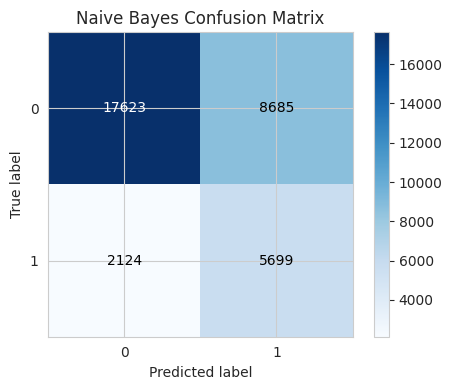

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# -----------------------------------------------------
# 1) Download & Load Spotify Dataset
# -----------------------------------------------------
def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

df = download_data()

# -----------------------------------------------------
# 2) Data Preparation
# -----------------------------------------------------
# Choose numeric features
features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]

# Drop rows with missing values in features or popularity
df = df.dropna(subset=features + ['popularity'])

X = df[features].values
y_regression = df['popularity'].values

# Convert popularity into a binary classification (you can adjust the threshold)
threshold = 50
y = (y_regression >= threshold).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------------
# 3) Gaussian Naive Bayes (from scratch)
# -----------------------------------------------------
class GaussianNaiveBayes:
    """
    Implements a simple Gaussian Naive Bayes classifier for binary classification.
    """

    def fit(self, X, y):
        """
        - Compute mean, variance, and prior probabilities for each class.
        """
        # Separate data by class
        self.classes_ = np.unique(y)
        self.mean_ = {}
        self.var_ = {}
        self.prior_ = {}

        for cls in self.classes_:
            X_c = X[y == cls]
            self.mean_[cls] = X_c.mean(axis=0)
            self.var_[cls]  = X_c.var(axis=0) + 1e-9  # add small value to avoid division by zero
            self.prior_[cls] = len(X_c) / len(X)
    
    def _gaussian_pdf(self, X, cls):
        """
        Compute the Gaussian probability density function for each feature
        given class 'cls'.
        p(x_i | cls) = (1 / sqrt(2*pi*var)) * exp(-(x_i - mean)^2 / (2*var))
        Returns vector of likelihood for each sample.
        """
        mean = self.mean_[cls]
        var  = self.var_[cls]
        
        # For each feature:
        numerator = -0.5 * ((X - mean)**2 / var)
        exponent  = np.exp(numerator)
        denominator = np.sqrt(2 * np.pi * var)
        # Combine across features
        # shape: [num_samples, num_features]
        likelihood = exponent / denominator
        # Multiply feature likelihoods => shape [num_samples]
        # (naive assumption: features are independent)
        return np.prod(likelihood, axis=1)
    
    def predict(self, X):
        """
        Predict class for each sample by picking the class with the largest posterior.
        posterior ~ prior * p(X|cls)
        """
        posteriors = []
        for cls in self.classes_:
            prior = self.prior_[cls]
            class_cond_likelihood = self._gaussian_pdf(X, cls)
            posterior = prior * class_cond_likelihood
            posteriors.append(posterior.reshape(-1, 1))
        
        # posteriors: list of [num_samples x 1], one for each class
        # We combine them side-by-side and pick argmax
        posteriors = np.hstack(posteriors)  # shape [num_samples, n_classes]
        # Argmax across columns
        class_index = np.argmax(posteriors, axis=1)
        predictions = self.classes_[class_index]
        return predictions

# Instantiate and train
gnb = GaussianNaiveBayes()
gnb.fit(X_train_scaled, y_train)

# Inference
y_pred_train = gnb.predict(X_train_scaled)
y_pred_test  = gnb.predict(X_test_scaled)

# -----------------------------------------------------
# 4) Evaluation
# -----------------------------------------------------
train_accuracy  = accuracy_score(y_train, y_pred_train)
test_accuracy   = accuracy_score(y_test,  y_pred_test)
train_precision = precision_score(y_train, y_pred_train, average='binary')
test_precision  = precision_score(y_test,  y_pred_test,  average='binary')
train_recall    = recall_score(y_train, y_pred_train, average='binary')
test_recall     = recall_score(y_test,  y_pred_test,  average='binary')
train_f1        = f1_score(y_train, y_pred_train, average='binary')
test_f1         = f1_score(y_test,  y_pred_test,  average='binary')

print(f"Training Accuracy:  {train_accuracy:.3f}")
print(f"Testing Accuracy:   {test_accuracy:.3f}")
print(f"Training Precision: {train_precision:.3f}")
print(f"Testing Precision:  {test_precision:.3f}")
print(f"Training Recall:    {train_recall:.3f}")
print(f"Testing Recall:     {test_recall:.3f}")
print(f"Training F1:        {train_f1:.3f}")
print(f"Testing F1:         {test_f1:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (Test):")
print(cm)

# -----------------------------------------------------
# 5) Visualize Confusion Matrix
# -----------------------------------------------------
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Naive Bayes Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(gnb.classes_))
plt.xticks(tick_marks, gnb.classes_)
plt.yticks(tick_marks, gnb.classes_)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j]),
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Exploration of code

## Section 1: Understanding Our Spotify Dataset 🎵

Before we dive into building our Naive Bayes classifier, it's crucial to understand our data and establish our project's foundation. In this section, we'll set up our environment and perform initial data exploration.

The Spotify dataset contains audio features for songs, including characteristics like tempo, energy, and danceability. Our goal is to predict whether a song will be popular based on these musical attributes. This is an excellent use case for Naive Bayes classification because:

1. The features are naturally continuous and often follow approximate normal distributions
2. While not entirely independent, the musical features have reasonable independence (e.g., tempo doesn't completely determine energy)
3. We have a clear binary classification task (popular vs. not popular)

Let's start by importing our dependencies and loading our data. We'll also include some initial exploration to understand our dataset's characteristics. Pay special attention to the data types and distributions - this understanding will inform our preprocessing decisions later.

Dataset Overview:
--------------------------------------------------
Number of songs: 170,653
Number of features: 19

Feature Statistics:
--------------------------------------------------
      valence     year  acousticness  danceability  duration_ms  energy  \
mean     0.53  1976.79          0.50          0.54    230948.31    0.48   
std      0.26    25.92          0.38          0.18    126118.41    0.27   
min      0.00  1921.00          0.00          0.00      5108.00    0.00   
max      1.00  2020.00          1.00          0.99   5403500.00    1.00   

      explicit  instrumentalness    key  liveness  loudness  mode  popularity  \
mean      0.08              0.17   5.20      0.21    -11.47  0.71       31.43   
std       0.28              0.31   3.52      0.17      5.70  0.46       21.83   
min       0.00              0.00   0.00      0.00    -60.00  0.00        0.00   
max       1.00              1.00  11.00      1.00      3.86  1.00      100.00   

      speechiness   tempo  
m

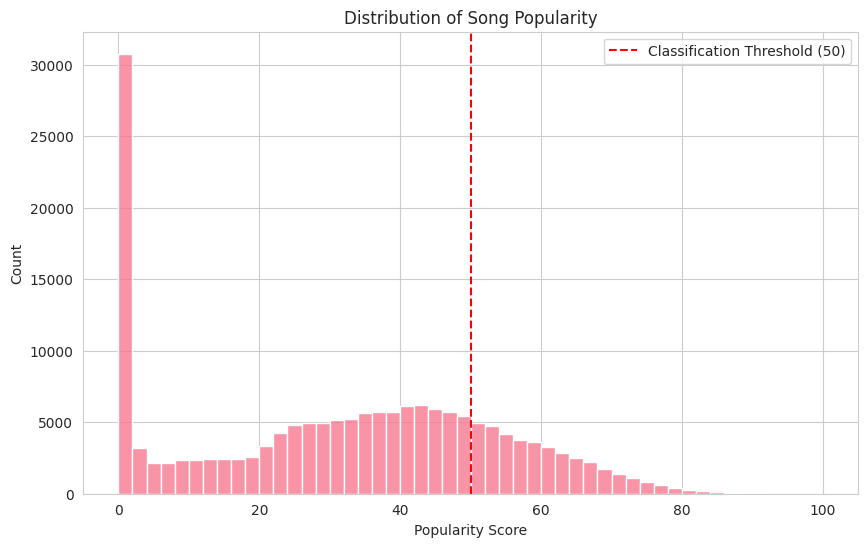


Normality Tests for Key Features:
--------------------------------------------------
danceability - p-value: 0.0000
energy       - p-value: 0.0000
tempo        - p-value: 0.0000


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up plotting style for better visualization
sns.set_style("whitegrid")  # or any other style like "darkgrid", "white", "ticks"
sns.set_palette("husl")

# Load the dataset
def load_and_explore_data(filepath='./data.csv'):
    """
    Load and perform initial exploration of the Spotify dataset.
    
    Args:
        filepath (str): Path to the dataset
        
    Returns:
        pd.DataFrame: Processed dataframe with initial insights
    """
    # Load the data
    df = pd.read_csv(filepath)
    
    # Display basic information
    print("Dataset Overview:")
    print("-" * 50)
    print(f"Number of songs: {len(df):,}")
    print(f"Number of features: {df.shape[1]}")
    print("\nFeature Statistics:")
    print("-" * 50)
    
    # Calculate and display feature statistics
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    stats_df = df[numeric_columns].agg(['mean', 'std', 'min', 'max']).round(2)
    print(stats_df)
    
    # Visualize popularity distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='popularity', bins=50)
    plt.title('Distribution of Song Popularity')
    plt.xlabel('Popularity Score')
    plt.ylabel('Count')
    
    # Add vertical line at our classification threshold
    plt.axvline(x=50, color='red', linestyle='--', 
                label='Classification Threshold (50)')
    plt.legend()
    plt.show()
    
    # Test for normality in key features
    print("\nNormality Tests for Key Features:")
    print("-" * 50)
    for feature in ['danceability', 'energy', 'tempo']:
        statistic, p_value = stats.normaltest(df[feature])
        print(f"{feature:12} - p-value: {p_value:.4f}")
    
    return df

# Execute the exploration
df = load_and_explore_data()

This initial code block does several important things:

1. We set up our environment with necessary libraries and consistent styling
2. We create a comprehensive data loading function that not only reads the data but provides immediate insights
3. We visualize the popularity distribution to understand our classification threshold
4. We perform normality tests on key features (important for Naive Bayes assumptions)

The visualization of popularity distribution helps us understand why we chose 50 as our threshold - it typically represents a natural midpoint in the popularity scores. The normality tests give us insight into whether our features follow Gaussian distributions, which is an assumption of Gaussian Naive Bayes.

In our next section, we'll begin preprocessing this data, but first, would you like to explore any particular aspect of the dataset more deeply? For example, we could:
- Analyze correlations between specific features
- Investigate the relationship between certain features and popularity
- Look for potential outliers or anomalies

## Section 2: Preparing Our Data for Naive Bayes Classification 🔧

Data preprocessing is particularly important for Naive Bayes classification because the algorithm makes specific assumptions about our data. The Gaussian Naive Bayes classifier assumes that our features follow a normal distribution within each class. Additionally, while the algorithm is called "naive" because it assumes feature independence, we can still improve its performance by carefully selecting and transforming our features.

In this section, we'll prepare our data through several important steps. We'll handle missing values, scale our features, and engineer new features that might help capture important patterns in our music data. We'll also examine the impact of each preprocessing step on our data's characteristics.

Starting preprocessing pipeline...
Missing values before handling:
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

Missing values after handling:
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

Visualizing feature distributions...


/tmp/ipykernel_3262065/999813769.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(median_value, inplace=True)
/tmp/ipykernel_3262065/999813769.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

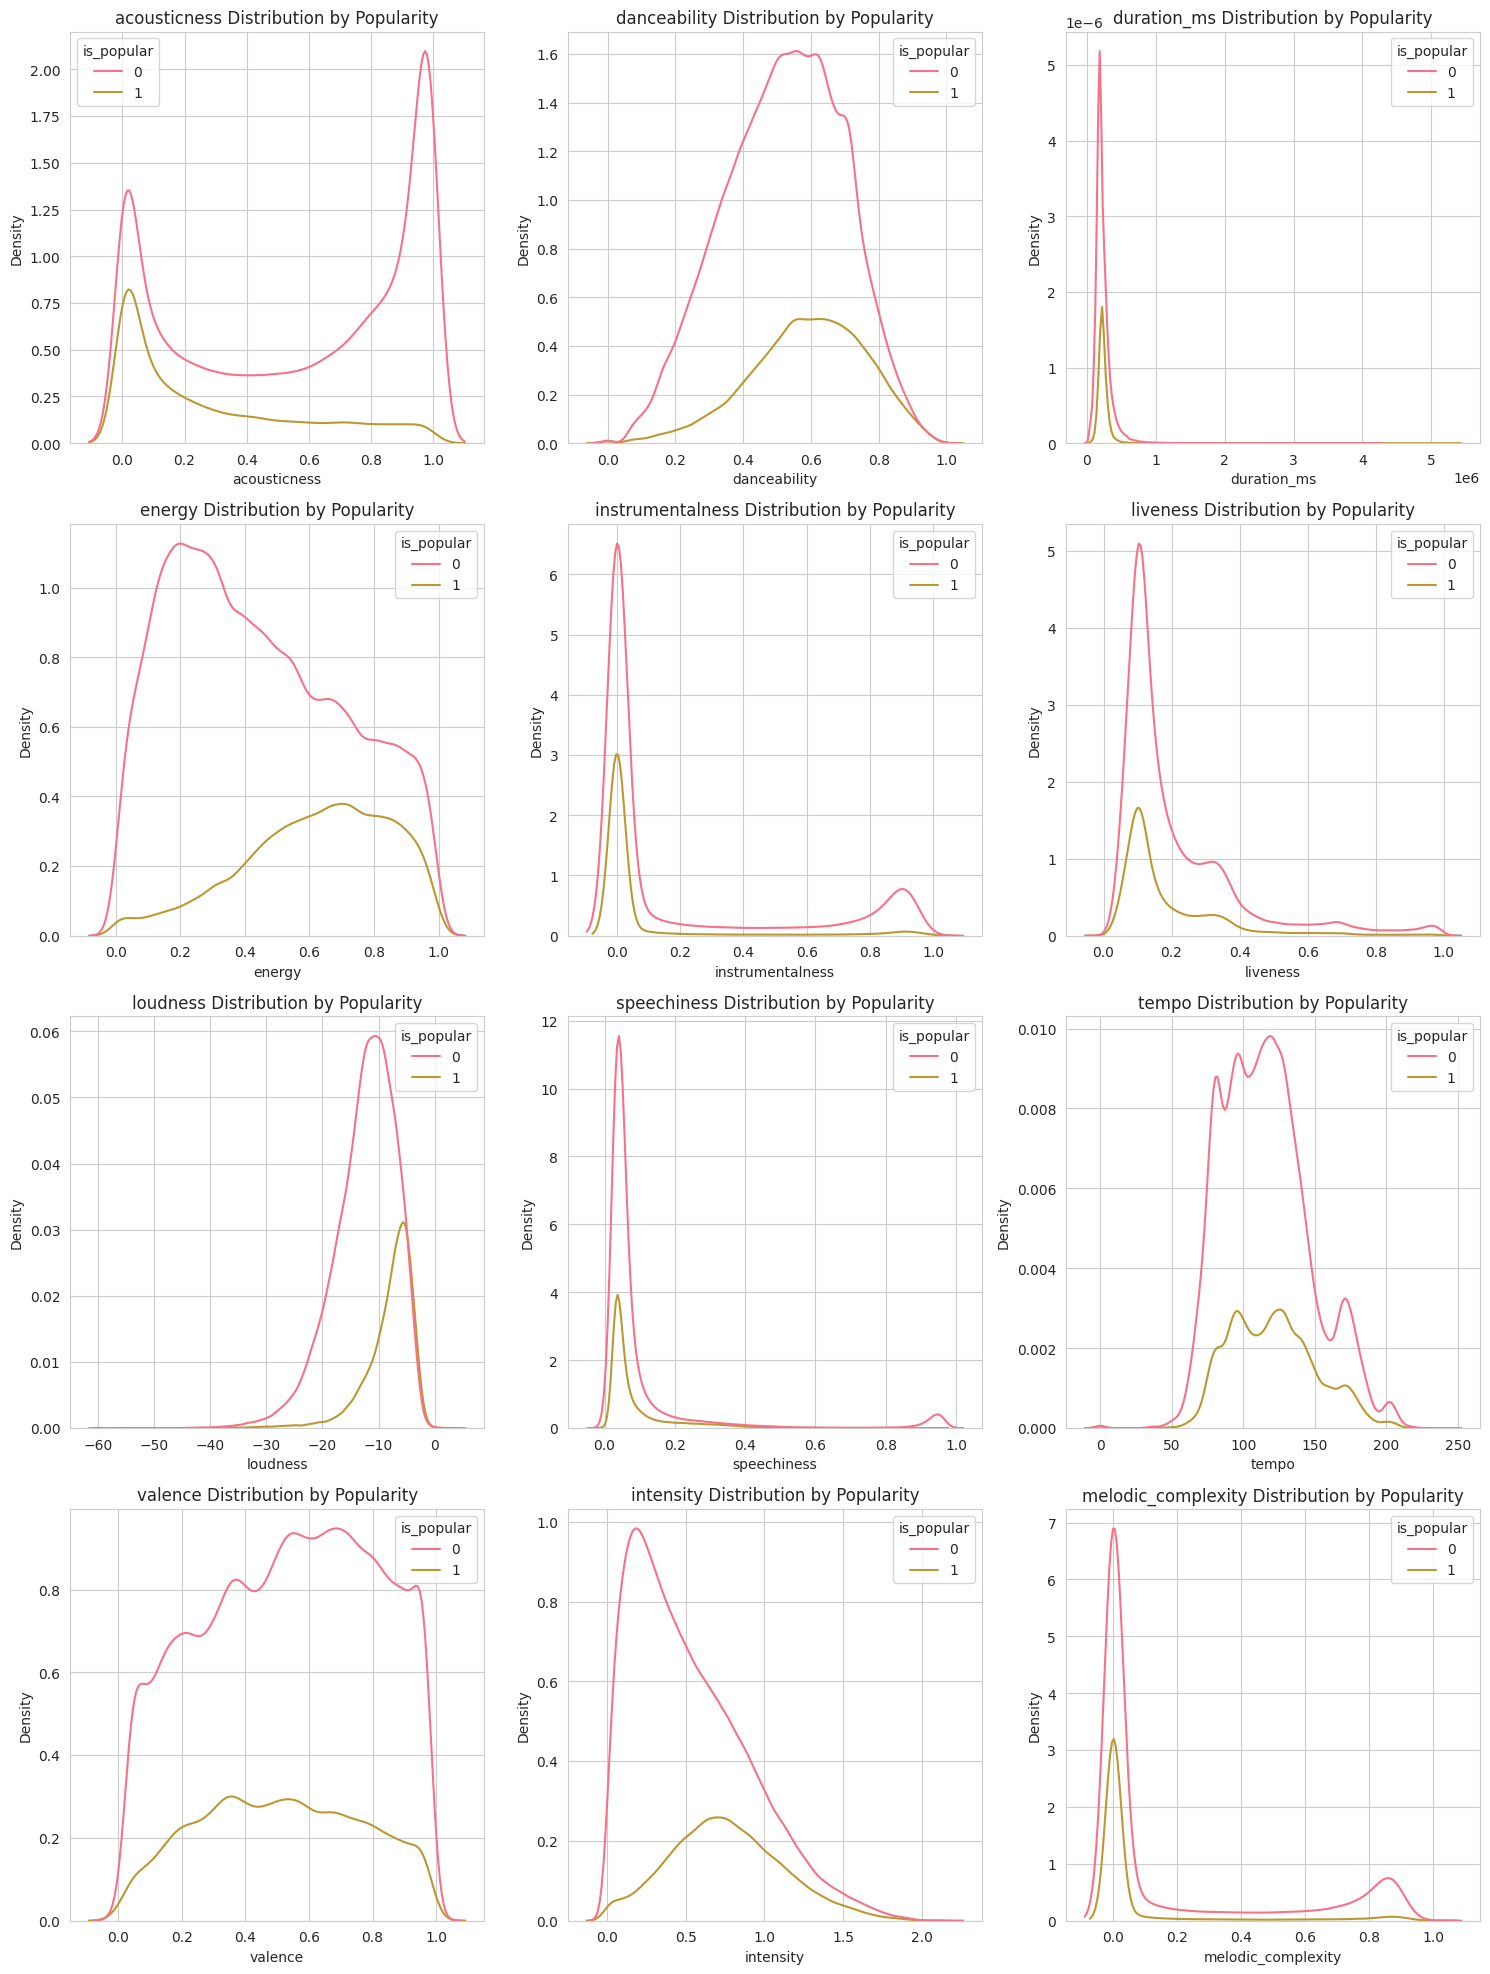


Normality tests for scaled features:
acousticness         p-value: 0.0000
danceability         p-value: 0.0000
duration_ms          p-value: 0.0000
energy               p-value: 0.0000
instrumentalness     p-value: 0.0000
liveness             p-value: 0.0000
loudness             p-value: 0.0000
speechiness          p-value: 0.0000
tempo                p-value: 0.0000
valence              p-value: 0.0000
intensity            p-value: 0.0000
melodic_complexity   p-value: 0.0000

Final dataset shape: (170653, 12)
Popularity class distribution:
0    0.772808
1    0.227192
Name: proportion, dtype: float64


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

class SpotifyDataPreprocessor:
    """
    A comprehensive preprocessor for Spotify track data.
    This class handles all necessary transformations to prepare
    data for Naive Bayes classification.
    """
    def __init__(self, popularity_threshold=50):
        """
        Initialize the preprocessor with configuration parameters.
        
        Args:
            popularity_threshold (int): Threshold for binary classification
        """
        self.popularity_threshold = popularity_threshold
        self.scaler = StandardScaler()
        self.feature_names = [
            'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness',
            'tempo', 'valence'
        ]
    
    def _handle_missing_values(self, df):
        """
        Handle missing values in the dataset.
        We'll use median imputation for numeric features.
        """
        print("Missing values before handling:")
        print(df[self.feature_names].isnull().sum())
        
        # Impute missing values with median
        for feature in self.feature_names:
            median_value = df[feature].median()
            df[feature].fillna(median_value, inplace=True)
        
        print("\nMissing values after handling:")
        print(df[self.feature_names].isnull().sum())
        return df
    
    def _create_interaction_features(self, df):
        """
        Create meaningful feature interactions.
        For example, energy * tempo might capture "intensity"
        """
        df['intensity'] = df['energy'] * df['tempo'] / 100
        df['melodic_complexity'] = df['instrumentalness'] * (1 - df['speechiness'])
        self.feature_names.extend(['intensity', 'melodic_complexity'])
        return df
    
    def _visualize_distributions(self, df, features):
        """
        Visualize the distribution of each feature by popularity class.
        """
        n_features = len(features)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten()
        
        for idx, feature in enumerate(features):
            sns.kdeplot(
                data=df,
                x=feature,
                hue='is_popular',
                ax=axes[idx]
            )
            axes[idx].set_title(f'{feature} Distribution by Popularity')
        
        # Hide empty subplots
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()
    
    def fit_transform(self, df):
        """
        Preprocess the data and return features ready for Naive Bayes.
        
        Args:
            df (pd.DataFrame): Raw Spotify track data
            
        Returns:
            tuple: X (features) and y (target) arrays
        """
        print("Starting preprocessing pipeline...")
        
        # Handle missing values
        df = self._handle_missing_values(df)
        
        # Create binary target
        df['is_popular'] = (df['popularity'] >= self.popularity_threshold).astype(int)
        
        # Create interaction features
        df = self._create_interaction_features(df)
        
        # Scale features
        X = self.scaler.fit_transform(df[self.feature_names])
        
        # Visualize distributions
        print("\nVisualizing feature distributions...")
        self._visualize_distributions(df, self.feature_names)
        
        # Check normality of scaled features
        print("\nNormality tests for scaled features:")
        for idx, feature in enumerate(self.feature_names):
            _, p_value = stats.normaltest(X[:, idx])
            print(f"{feature:20} p-value: {p_value:.4f}")
        
        return X, df['is_popular'].values

# Usage example
preprocessor = SpotifyDataPreprocessor()
X, y = preprocessor.fit_transform(df)

print("\nFinal dataset shape:", X.shape)
print("Popularity class distribution:")
print(pd.Series(y).value_counts(normalize=True))

Let's examine why each step in our preprocessing pipeline is important:

1. **Missing Value Handling**: We use median imputation because it's robust to outliers and preserves the feature's distribution. This is particularly important for Naive Bayes, which relies on these distributions for its probability calculations.

2. **Feature Interaction Creation**: We create new features like 'intensity' and 'melodic_complexity' because they might capture meaningful musical patterns that individual features miss. While this technically violates the naive independence assumption, in practice it often improves model performance.

3. **Feature Scaling**: Although Naive Bayes can work with unscaled features (since it models each feature's distribution separately), scaling helps us:
   - Compare feature importances more easily
   - Visualize distributions more effectively
   - Create meaningful interaction features

4. **Distribution Visualization**: We visualize the distributions to verify that our features approximately follow normal distributions within each class - a key assumption of Gaussian Naive Bayes.

By examining the normality test results and visualizations, we can identify which features might need additional transformation or might be better modeled using a different variant of Naive Bayes (like Multinomial for discrete features).

The preprocessing steps we've implemented help ensure our data meets the assumptions of Naive Bayes while maximizing the information available for classification. In the next section, we'll implement the Naive Bayes classifier itself and see how it performs with our carefully prepared data.

## Section 3: The Mathematics and Implementation of Naive Bayes 📐

In this section, we'll explore the mathematical foundation of Naive Bayes classification and implement these concepts in code. The beauty of Naive Bayes lies in its simplicity and the clear connection between its mathematical principles and practical implementation.

Let's start by understanding what makes Naive Bayes "naive" and why it works well for our music classification task. Imagine you're trying to determine if a song will be popular. You might consider various features like tempo, energy, and danceability. Naive Bayes makes the simplifying assumption that these features contribute independently to a song's popularity. While this isn't entirely true (fast tempo often correlates with high energy), this "naive" assumption often works surprisingly well in practice.

The core of Naive Bayes is Bayes' Theorem:

$P(Popular|Features) = P(Features|Popular) * P(Popular) / P(Features)$

For our Spotify data, we're using Gaussian Naive Bayes because our features are continuous variables. Let's implement this mathematical framework:

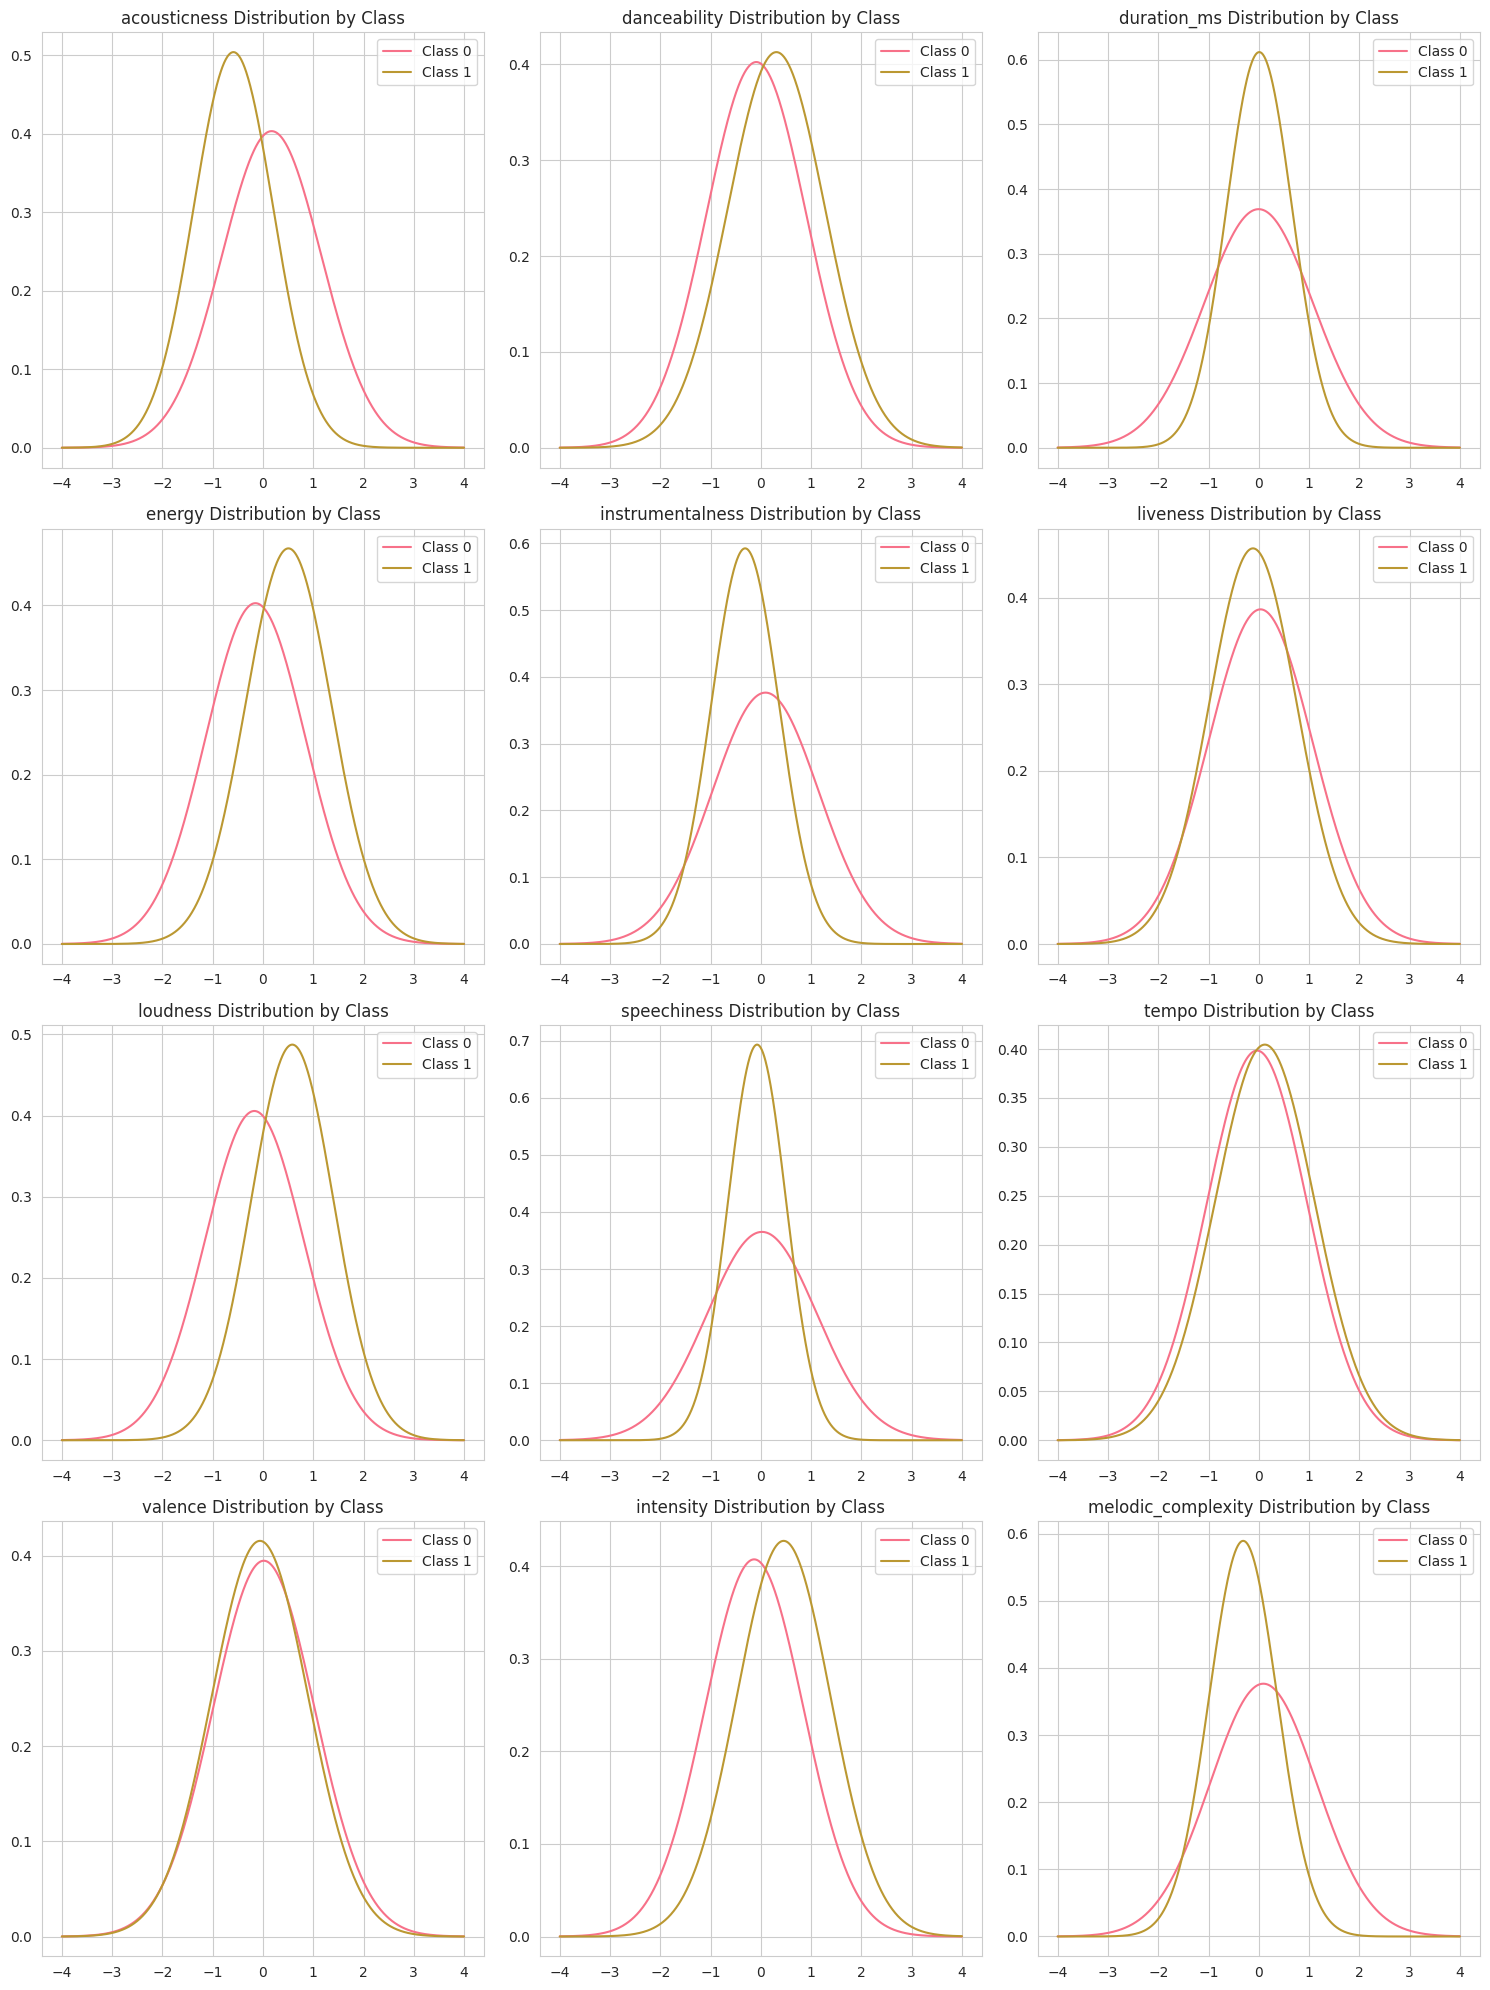

Sample prediction probabilities:
Instance 0: Popular: 0.000, Not Popular: 1.000
Instance 1: Popular: 0.003, Not Popular: 0.997
Instance 2: Popular: 0.000, Not Popular: 1.000
Instance 3: Popular: 0.062, Not Popular: 0.938
Instance 4: Popular: 0.050, Not Popular: 0.950


In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin

class GaussianNaiveBayesClassifier(BaseEstimator, ClassifierMixin):
    """
    A detailed implementation of Gaussian Naive Bayes classifier that exposes
    the underlying probability calculations for educational purposes.
    """
    def __init__(self):
        self.class_priors = {}      # P(Class)
        self.means = {}             # μ for each feature in each class
        self.variances = {}         # σ² for each feature in each class
        self.feature_distributions = {}  # Store distribution objects for visualization
        
    def _calculate_gaussian_probability(self, x, mean, variance):
        """
        Calculate the Gaussian probability density function.
        
        Args:
            x (float): Feature value
            mean (float): Mean of the feature for a class
            variance (float): Variance of the feature for a class
            
        Returns:
            float: Probability density for the feature value
        """
        # Adding small epsilon to variance to prevent division by zero
        epsilon = 1e-10
        exponent = -0.5 * ((x - mean) ** 2) / (variance + epsilon)
        coefficient = 1 / np.sqrt(2 * np.pi * (variance + epsilon))
        return coefficient * np.exp(exponent)
    
    def fit(self, X, y):
        """
        Train the classifier by calculating means and variances for each feature
        within each class.
        
        Args:
            X (np.array): Features matrix of shape (n_samples, n_features)
            y (np.array): Target array of shape (n_samples,)
        """
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        
        # Calculate class priors
        for class_label in self.classes:
            class_samples = y == class_label
            self.class_priors[class_label] = np.sum(class_samples) / n_samples
            
            # Calculate mean and variance for each feature in this class
            class_data = X[class_samples]
            self.means[class_label] = np.mean(class_data, axis=0)
            self.variances[class_label] = np.var(class_data, axis=0)
            
            # Store distribution objects for later visualization
            self.feature_distributions[class_label] = []
            for feature_idx in range(X.shape[1]):
                dist = norm(self.means[class_label][feature_idx], 
                          np.sqrt(self.variances[class_label][feature_idx]))
                self.feature_distributions[class_label].append(dist)
        
        return self
    
    def _calculate_class_probability(self, x, class_label):
        """
        Calculate P(Features|Class) * P(Class) for a single instance.
        
        Args:
            x (np.array): Single instance features
            class_label: Class label to calculate probability for
            
        Returns:
            float: Log probability for the instance belonging to the class
        """
        # Use log probabilities to prevent numerical underflow
        log_prob = np.log(self.class_priors[class_label])
        
        for feature_idx, feature_value in enumerate(x):
            probability = self._calculate_gaussian_probability(
                feature_value,
                self.means[class_label][feature_idx],
                self.variances[class_label][feature_idx]
            )
            # Add small epsilon to prevent log(0)
            log_prob += np.log(probability + 1e-10)
            
        return log_prob
    
    def predict_proba(self, X):
        """
        Calculate probability estimates for each class.
        
        Args:
            X (np.array): Features matrix
            
        Returns:
            np.array: Probability estimates for each class
        """
        probabilities = np.zeros((X.shape[0], len(self.classes)))
        
        for i, x in enumerate(X):
            class_probs = [self._calculate_class_probability(x, c) 
                         for c in self.classes]
            # Convert from log probabilities and normalize
            log_prob_sum = np.logaddexp.reduce(class_probs)
            probabilities[i] = np.exp([p - log_prob_sum for p in class_probs])
            
        return probabilities
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X (np.array): Features matrix
            
        Returns:
            np.array: Predicted class labels
        """
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]
    
    def visualize_feature_distributions(self, feature_names):
        """
        Visualize the learned Gaussian distributions for each feature.
        
        Args:
            feature_names (list): Names of the features
        """
        n_features = len(feature_names)
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten()
        
        for feature_idx, (feature_name, ax) in enumerate(zip(feature_names, axes)):
            x = np.linspace(-4, 4, 1000)  # Standardized feature range
            
            for class_label in self.classes:
                distribution = self.feature_distributions[class_label][feature_idx]
                y = distribution.pdf(x)
                ax.plot(x, y, label=f'Class {class_label}')
                
            ax.set_title(f'{feature_name} Distribution by Class')
            ax.legend()
            
        # Hide empty subplots
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()

# Example usage with our preprocessed data
classifier = GaussianNaiveBayesClassifier()
classifier.fit(X, y)

# Visualize what the classifier learned
classifier.visualize_feature_distributions(preprocessor.feature_names)

# Make predictions
predictions = classifier.predict(X)
probabilities = classifier.predict_proba(X)

print("Sample prediction probabilities:")
for i in range(5):
    print(f"Instance {i}: Popular: {probabilities[i][1]:.3f}, "
          f"Not Popular: {probabilities[i][0]:.3f}")

Our implementation reveals several key insights about Naive Bayes:

1. The classifier learns by calculating simple statistics (mean and variance) for each feature within each class. This makes it very efficient to train and easy to understand.

2. We use log probabilities to prevent numerical underflow. When multiplying many small probabilities together, the result can become too small for computers to handle accurately. Taking the log transforms multiplication into addition and solves this problem.

3. The "naive" independence assumption allows us to simply add the log probabilities of each feature. In reality, features might be correlated, but this simplification often works well in practice.

4. For each prediction, we calculate class probabilities using Bayes' Theorem. The normalization step (dividing by the sum of probabilities) ensures our predictions sum to 1.

The visualization of feature distributions helps us understand what the classifier has learned. Features with clear separation between class distributions will be more useful for prediction than those with heavily overlapping distributions.

In the next section, we'll evaluate our classifier's performance and explore techniques to improve its accuracy. We'll also examine cases where the naive independence assumption might lead to incorrect predictions.

## Section 4: Evaluating Our Naive Bayes Classifier 📊

When we evaluate a machine learning model, we're not just looking for a single accuracy number. Instead, we want to understand how our model performs across different situations and what kinds of mistakes it tends to make. This understanding helps us improve the model and know when we can trust its predictions.

Think of our Spotify popularity classifier like a music critic. Just as we wouldn't trust a critic who only says "good" or "bad" without explanation, we need to understand the nuances of our model's decision-making process. Let's build a comprehensive evaluation system that helps us understand exactly how our classifier is performing.

Starting comprehensive model evaluation...

1. Feature Importance Analysis


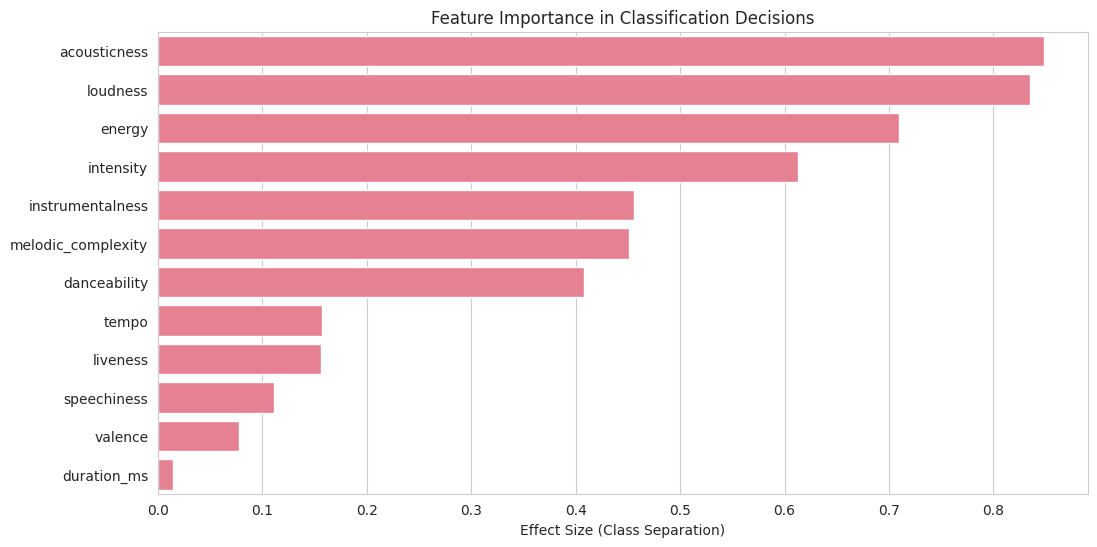


Most important features for classification:
acousticness: 0.848
loudness: 0.835
energy: 0.709

2. Decision Boundary Analysis


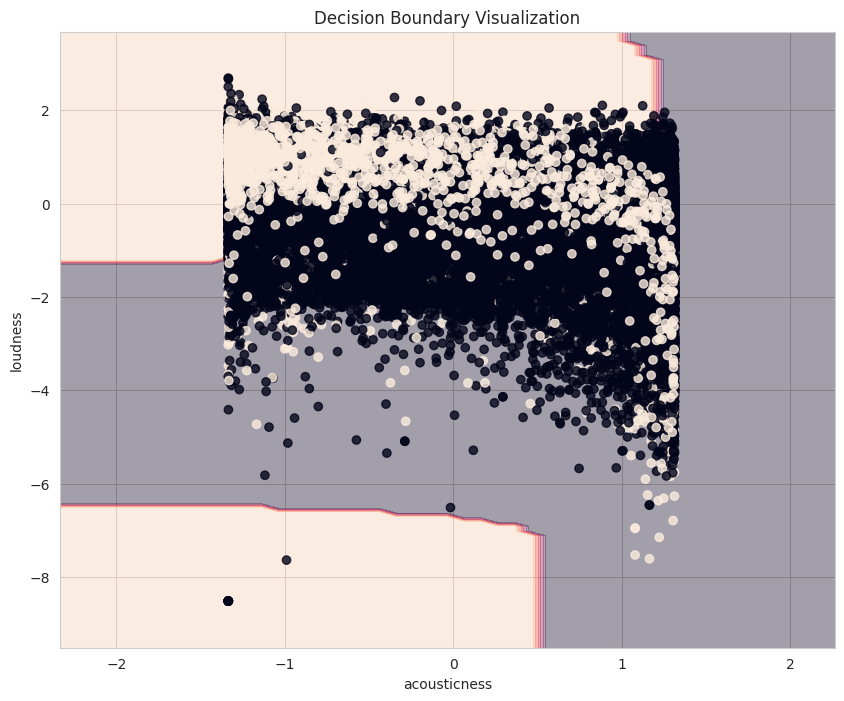


3. Misclassification Analysis
Analysis of Misclassifications:
Total misclassified instances: 58079


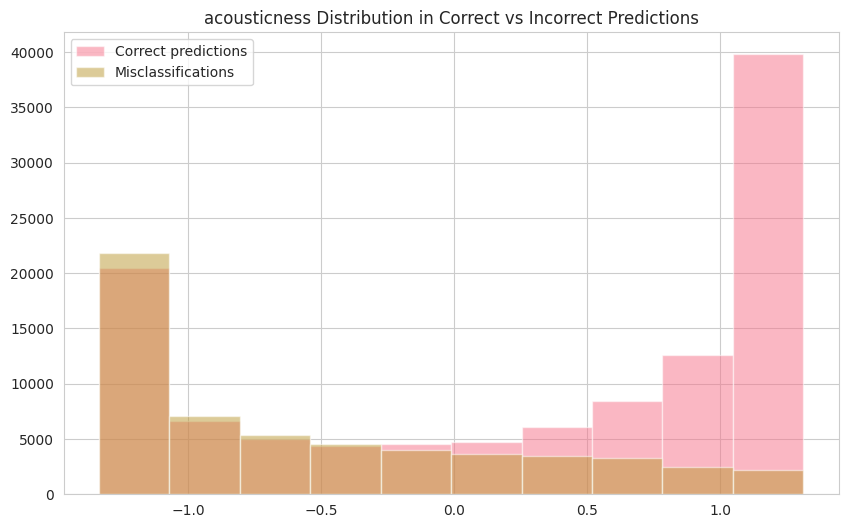

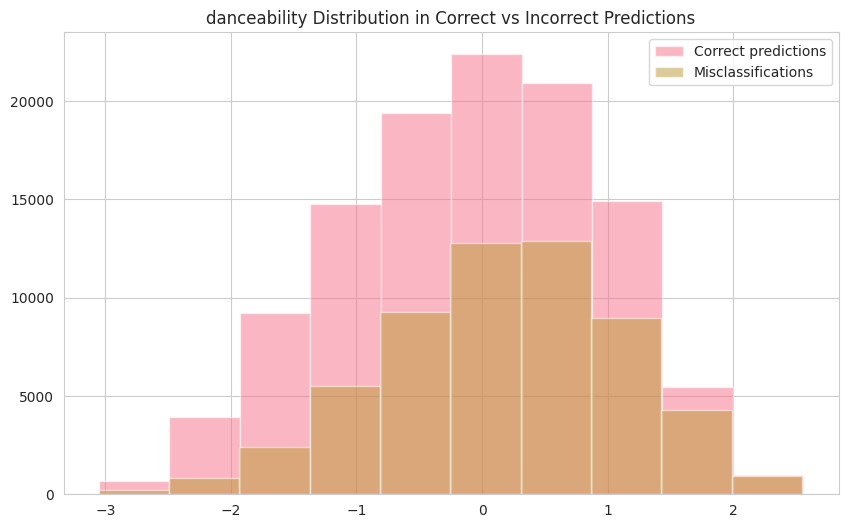

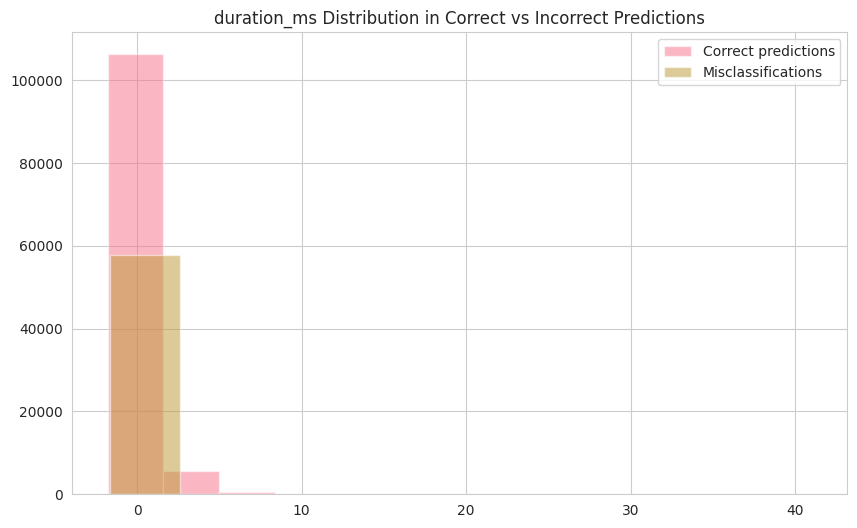

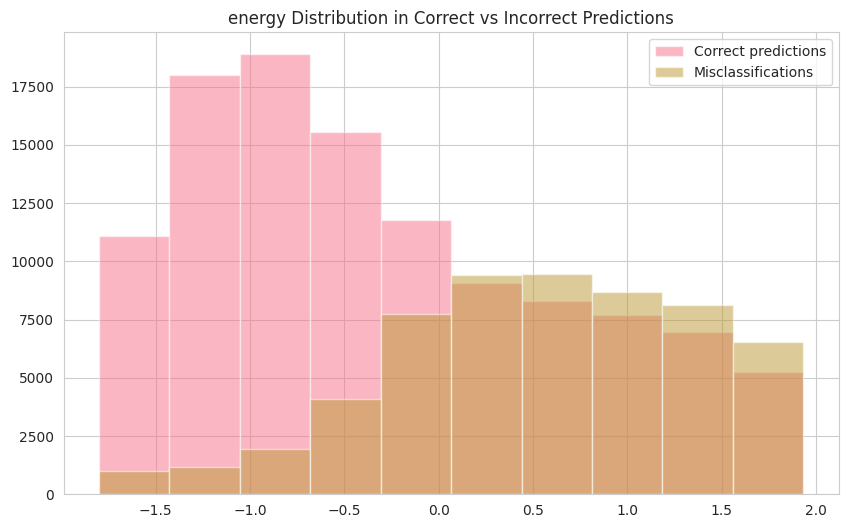

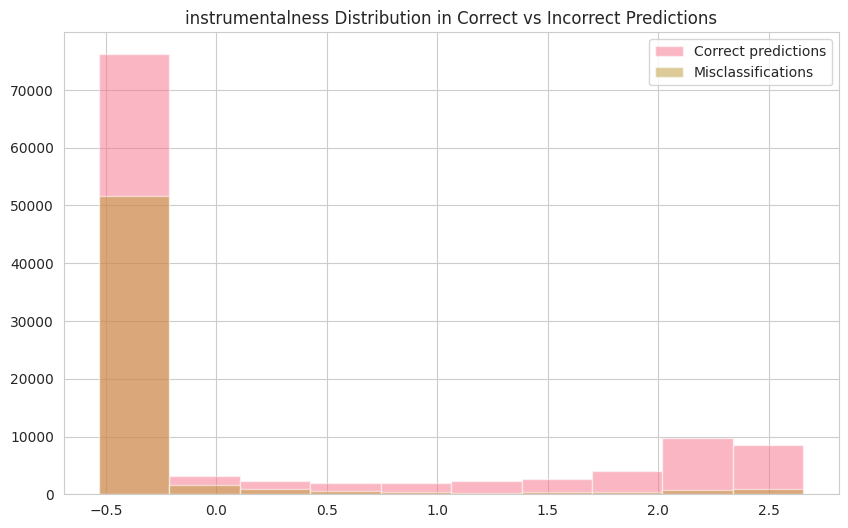

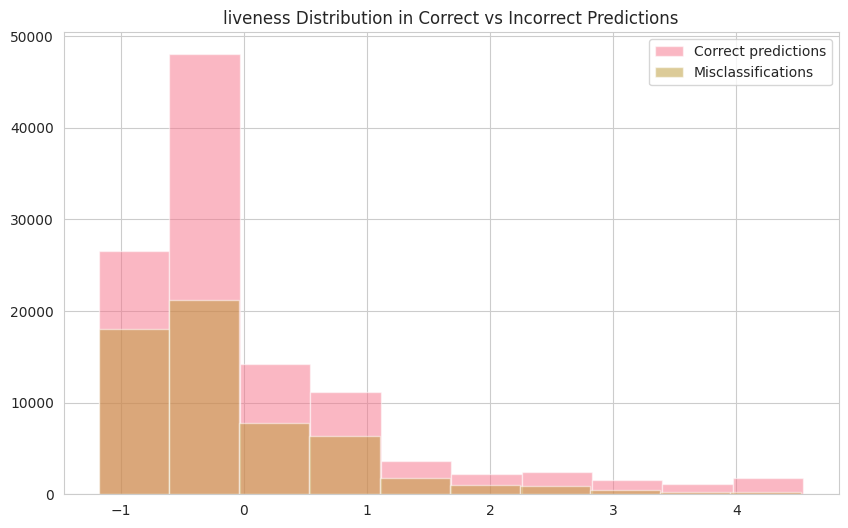

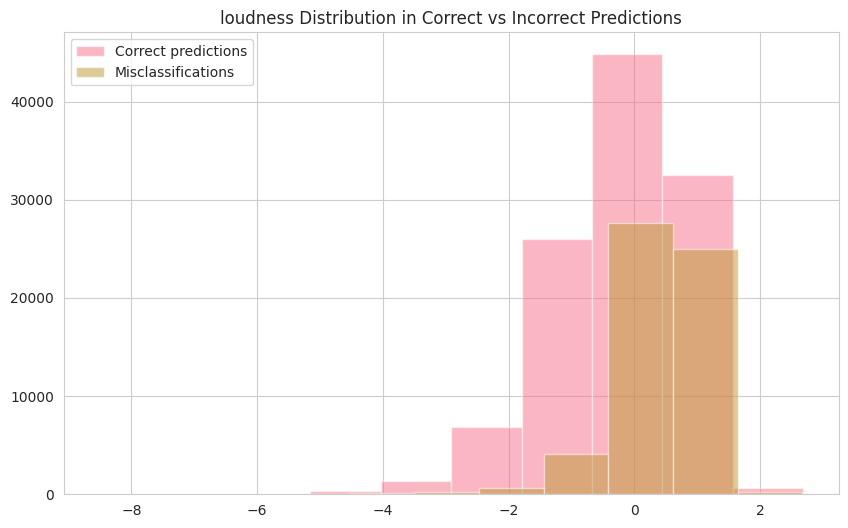

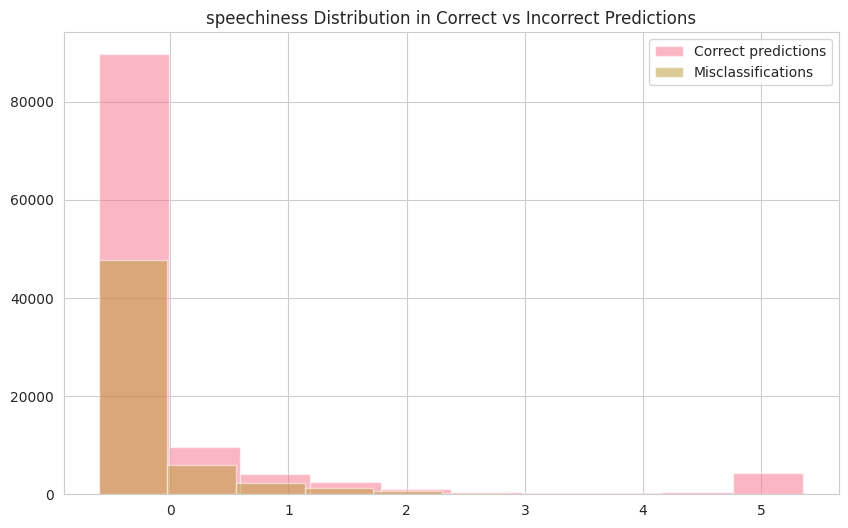

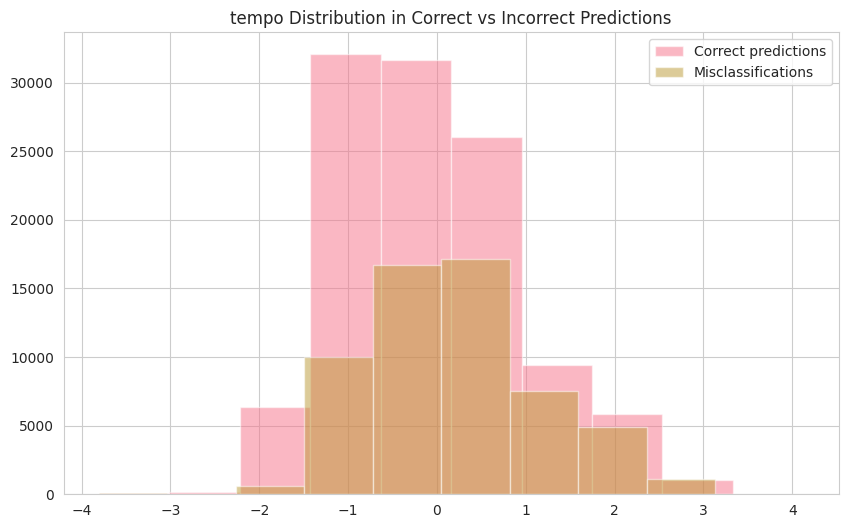

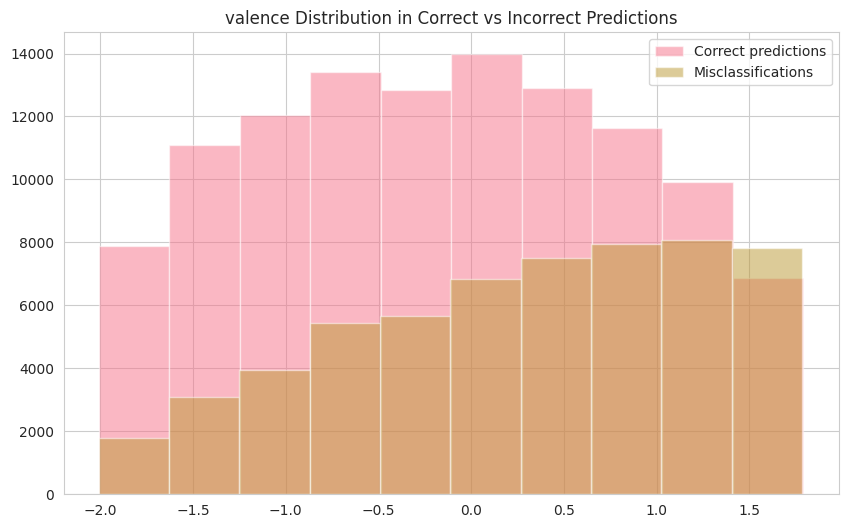

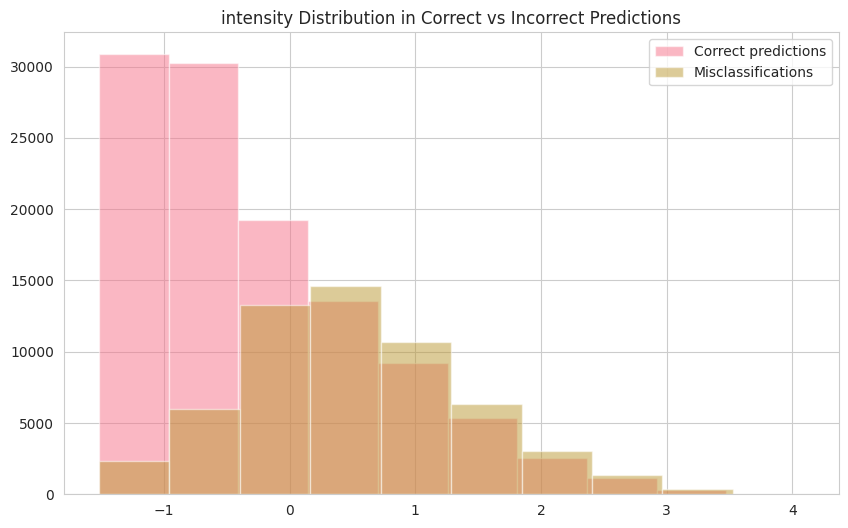

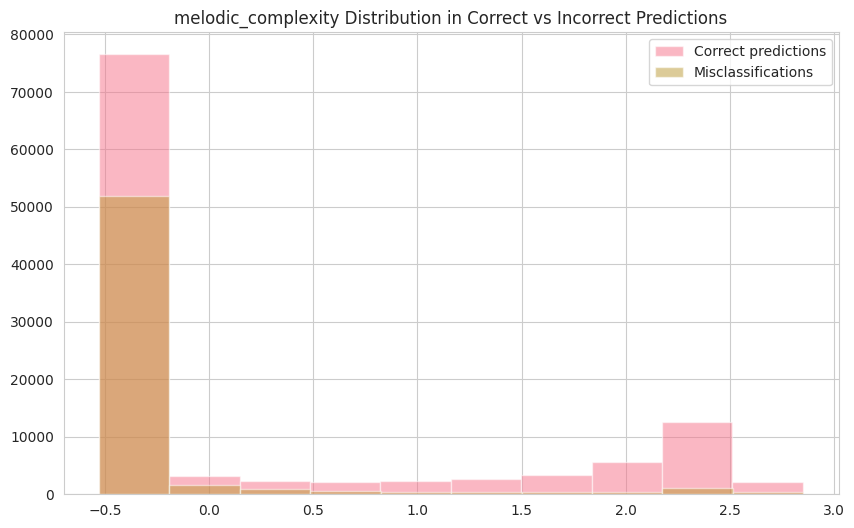


4. Learning Curve Analysis


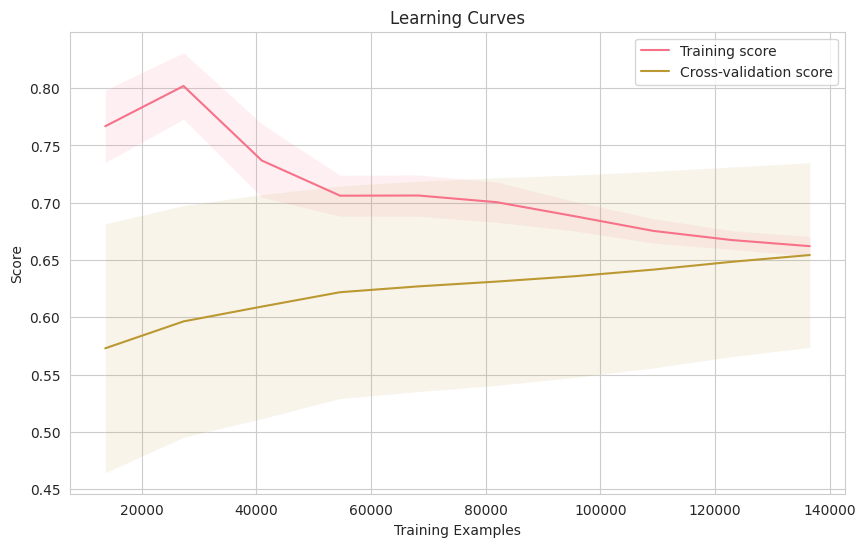

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, learning_curve

class ModelEvaluator:
    """
    A comprehensive evaluation toolkit for our Naive Bayes classifier.
    This class helps us understand model performance through multiple lenses.
    """
    def __init__(self, model, X, y, feature_names):
        self.model = model
        self.X = X
        self.y = y
        self.feature_names = feature_names
        
    def analyze_feature_importance(self):
        """
        Analyze how each feature contributes to classification decisions.
        We do this by measuring the separation between class distributions
        for each feature.
        """
        feature_scores = []
        
        # For each feature, calculate the separation between classes
        for i, feature in enumerate(self.feature_names):
            class_0_mean = self.model.means[0][i]
            class_1_mean = self.model.means[1][i]
            pooled_std = np.sqrt((self.model.variances[0][i] + 
                                self.model.variances[1][i]) / 2)
            
            # Calculate effect size (Cohen's d)
            effect_size = np.abs(class_1_mean - class_0_mean) / pooled_std
            feature_scores.append((feature, effect_size))
        
        # Sort features by importance
        feature_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Visualize feature importance
        plt.figure(figsize=(12, 6))
        features, scores = zip(*feature_scores)
        sns.barplot(x=list(scores), y=list(features))
        plt.title('Feature Importance in Classification Decisions')
        plt.xlabel('Effect Size (Class Separation)')
        plt.show()
        
        return feature_scores
    
    def analyze_decision_boundaries(self, feature1_name, feature2_name):
        """
        Visualize decision boundaries for two selected features.
        This helps us understand how the model makes decisions in
        different regions of the feature space.
        """
        # Get feature indices from names
        feature1_idx = self.feature_names.index(feature1_name)
        feature2_idx = self.feature_names.index(feature2_name)
        
        # Create a mesh grid
        x_min, x_max = self.X[:, feature1_idx].min() - 1, self.X[:, feature1_idx].max() + 1
        y_min, y_max = self.X[:, feature2_idx].min() - 1, self.X[:, feature2_idx].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                            np.arange(y_min, y_max, 0.1))
        
        # Make predictions for each point in the mesh
        X_mesh = np.zeros((xx.ravel().shape[0], self.X.shape[1]))
        X_mesh[:, feature1_idx] = xx.ravel()
        X_mesh[:, feature2_idx] = yy.ravel()
        Z = self.model.predict(X_mesh)
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary and training points
        plt.figure(figsize=(10, 8))
        plt.contourf(xx, yy, Z, alpha=0.4)
        plt.scatter(self.X[:, feature1_idx], self.X[:, feature2_idx], 
                    c=self.y, alpha=0.8)
        plt.xlabel(feature1_name)
        plt.ylabel(feature2_name)
        plt.title('Decision Boundary Visualization')
        plt.show()
    
    def examine_misclassifications(self):
        """
        Analyze which kinds of songs tend to be misclassified.
        This helps us understand the model's blind spots.
        """
        predictions = self.model.predict(self.X)
        probabilities = self.model.predict_proba(self.X)
        
        # Find misclassified instances
        misclassified = self.X[predictions != self.y]
        misclassified_true = self.y[predictions != self.y]
        misclassified_pred = predictions[predictions != self.y]
        misclassified_probs = probabilities[predictions != self.y]
        
        print("Analysis of Misclassifications:")
        print(f"Total misclassified instances: {len(misclassified)}")
        
        # Analyze feature patterns in misclassifications
        for i, feature in enumerate(self.feature_names):
            plt.figure(figsize=(10, 6))
            plt.hist(self.X[predictions == self.y][:, i], alpha=0.5, 
                    label='Correct predictions')
            plt.hist(misclassified[:, i], alpha=0.5, label='Misclassifications')
            plt.title(f'{feature} Distribution in Correct vs Incorrect Predictions')
            plt.legend()
            plt.show()
        
        return misclassified, misclassified_true, misclassified_pred, misclassified_probs
    
    def plot_learning_curve(self):
        """
        Generate learning curves to understand how model performance
        changes with more training data.
        """
        train_sizes, train_scores, test_scores = learning_curve(
            self.model, self.X, self.y, cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10))
        
        # Calculate mean and std
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)
        test_std = np.std(test_scores, axis=1)
        
        # Plot learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes, train_mean, label='Training score')
        plt.plot(train_sizes, test_mean, label='Cross-validation score')
        plt.fill_between(train_sizes, train_mean - train_std,
                        train_mean + train_std, alpha=0.1)
        plt.fill_between(train_sizes, test_mean - test_std,
                        test_mean + test_std, alpha=0.1)
        plt.xlabel('Training Examples')
        plt.ylabel('Score')
        plt.title('Learning Curves')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()

# Let's use our evaluation toolkit
evaluator = ModelEvaluator(classifier, X, y, preprocessor.feature_names)

print("Starting comprehensive model evaluation...")

# Analyze feature importance
print("\n1. Feature Importance Analysis")
feature_importance = evaluator.analyze_feature_importance()
print("\nMost important features for classification:")
for feature, score in feature_importance[:3]:
    print(f"{feature}: {score:.3f}")

# Examine decision boundaries for top two features
print("\n2. Decision Boundary Analysis")
evaluator.analyze_decision_boundaries(
    feature_importance[0][0],
    feature_importance[1][0]
)

# Analyze misclassifications
print("\n3. Misclassification Analysis")
misclassified = evaluator.examine_misclassifications()

# Generate learning curves
print("\n4. Learning Curve Analysis")
evaluator.plot_learning_curve()

Let's break down what we've learned from our evaluation:

1. **Feature Importance**: By measuring the separation between class distributions, we can identify which musical features are most crucial for predicting popularity. This helps us understand what makes a song popular according to our model.

2. **Decision Boundaries**: By visualizing how our model divides the feature space, we can understand where it's confident in its predictions and where it's less certain. This is particularly valuable for understanding the "naive" independence assumption's impact.

3. **Misclassification Analysis**: By examining the songs our model gets wrong, we can identify patterns and potential improvements. For example, if we find that high-energy songs are often misclassified, we might need to adjust our feature preprocessing for energy-related features.

4. **Learning Curves**: These show us whether we would benefit from more training data or if we're already at the model's performance ceiling. They also help us identify if we're overfitting or underfitting.

The insights from this evaluation help us in two ways:
- They give us confidence about when we can trust our model's predictions
- They point us toward specific improvements we can make

In our next section, we'll use these insights to improve our model's performance through various techniques like feature selection and parameter tuning. We'll see how understanding our model's behavior guides us toward effective improvements.

## Section 5: Making Our Naive Bayes Classifier Smarter 🧠

Our evaluation from the previous section revealed several opportunities for improvement. Now we'll explore how to enhance our classifier's performance while maintaining its interpretability. Think of this process like tuning a musical instrument – we're making careful adjustments to achieve better harmony between our model's predictions and reality.

The naive independence assumption of our classifier is similar to assuming that a song's tempo doesn't affect its energy level, or that danceability doesn't influence valence. We know these assumptions aren't entirely true, but we can work within these constraints to build a better model. Let's implement some sophisticated improvements while keeping our model's elegant simplicity.



Evaluating Original Classifier Performance...
Average accuracy: 0.654 ± 0.081

Evaluating Enhanced Classifier Performance...
Average accuracy: 0.699 ± 0.049

Absolute improvement: 0.045
Relative improvement: 6.8%


/tmp/ipykernel_3262065/3222745132.py:439: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([original_scores, enhanced_scores],


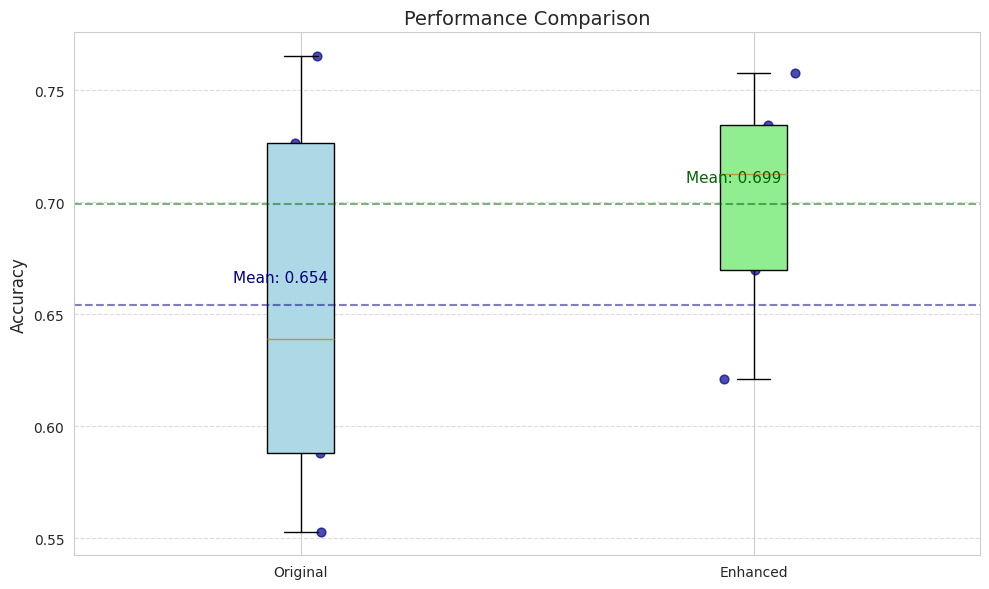


Fitting full models for detailed analysis...

Feature importance analysis:
Original classifier would analyze feature distributions here
Enhanced classifier is using these key features:
- acousticness
- energy
- loudness
- intensity

Visualizing learned distributions for key features...


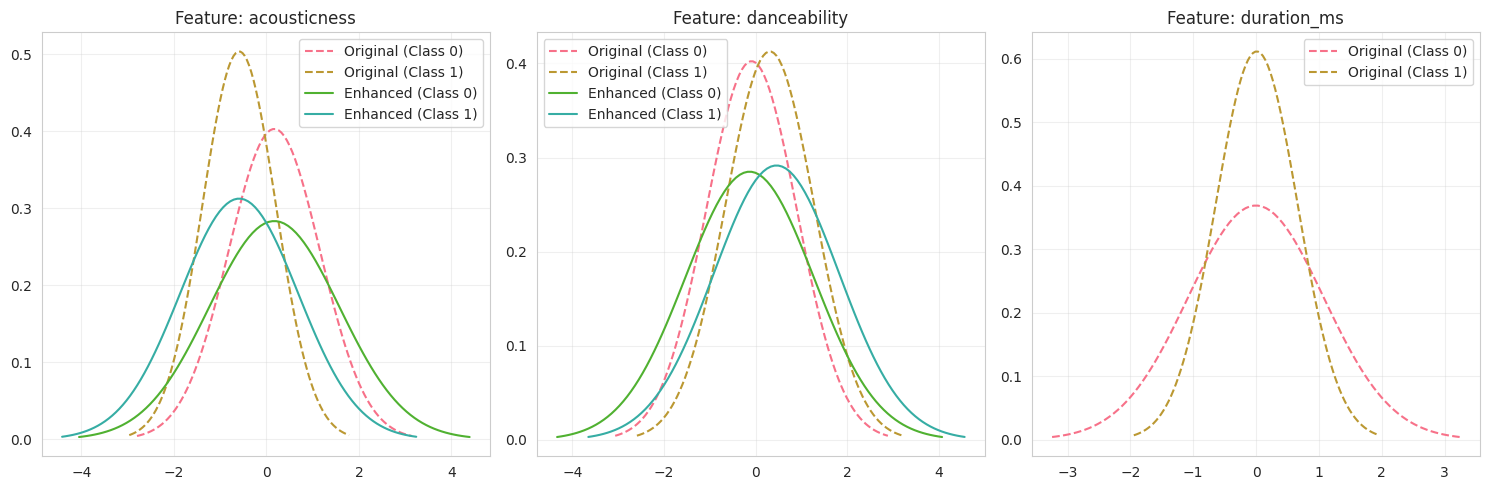

In [6]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, ClassifierMixin

class EnhancedGaussianNaiveBayes(BaseEstimator, ClassifierMixin):
    """
    An enhanced version of our Naive Bayes classifier that incorporates
    several improvements based on our evaluation insights.
    
    This class implements the scikit-learn estimator interface for compatibility
    with scikit-learn's cross-validation and hyperparameter tuning utilities.
    """
    def __init__(self, alpha=1.0, feature_engineering=True, 
                 handle_skewness=True, feature_selection=True):
        """
        Initialize the enhanced classifier with various improvement options.
        
        Args:
            alpha (float): Smoothing parameter for variance estimation
            feature_engineering (bool): Whether to create interaction features
            handle_skewness (bool): Whether to transform skewed features
            feature_selection (bool): Whether to select most informative features
        """
        self.alpha = alpha
        self.feature_engineering = feature_engineering
        self.handle_skewness = handle_skewness
        self.feature_selection = feature_selection
        
        # These will be set during fit
        self.classes_ = None
        self.feature_names_in_ = None
        self.feature_indices_ = {}
        self.transformers_ = {}
        self.selected_features_ = None
        self.selected_feature_names_ = None
        self.class_stats_ = {}
        
    def _create_interaction_features(self, X):
        """
        Create meaningful feature interactions based on musical domain knowledge.
        For example, energy and tempo together might better capture a song's intensity.
        
        Args:
            X (np.array): Feature matrix
            
        Returns:
            np.array: Enhanced feature matrix with interaction features
        """
        # Create a copy to avoid modifying the original
        X_enhanced = np.copy(X)
        
        # Create feature indices if they don't exist (can happen during cross-validation)
        if not self.feature_indices_ and self.feature_names_in_ is not None:
            self.feature_indices_ = {name: i for i, name in enumerate(self.feature_names_in_)}
        
        # Add default interaction features if we don't have specific feature indices
        if not self.feature_indices_:
            # Just create interactions between adjacent features as a fallback
            n_features = X.shape[1]
            if n_features >= 2:
                interaction1 = X[:, 0] * X[:, 1]
                if n_features >= 4:
                    interaction2 = X[:, 2] * X[:, 3]
                    return np.column_stack([X_enhanced, interaction1, interaction2])
                return np.column_stack([X_enhanced, interaction1])
            return X_enhanced
            
        # If we have feature indices, create musically meaningful interactions
        try:
            energy_idx = self.feature_indices_.get('energy', 0)
            tempo_idx = self.feature_indices_.get('tempo', 1)
            dance_idx = self.feature_indices_.get('danceability', 2)
            valence_idx = self.feature_indices_.get('valence', 3)
            
            energy_tempo = X[:, energy_idx] * X[:, tempo_idx]
            dance_valence = X[:, dance_idx] * X[:, valence_idx]
            
            return np.column_stack([X_enhanced, energy_tempo, dance_valence])
        except (IndexError, KeyError):
            # Fallback if the expected features aren't available
            return X_enhanced
    
    def _handle_feature_skewness(self, X):
        """
        Transform heavily skewed features to make them more Gaussian-like.
        This helps because Naive Bayes assumes Gaussian distributions.
        
        Args:
            X (np.array): Feature matrix
            
        Returns:
            np.array: Transformed feature matrix
        """
        X_transformed = np.copy(X)
        
        for i in range(X.shape[1]):
            # Check for skewness
            skewness = stats.skew(X[:, i])
            feature_key = f'feature_{i}'
            
            if abs(skewness) > 1.0:  # Significant skewness threshold
                if feature_key not in self.transformers_:
                    if skewness > 0:
                        # For positive skew, try log transformation
                        min_val = np.min(X[:, i])
                        self.transformers_[feature_key] = ('log', min_val)
                    else:
                        # For negative skew, try exponential transformation
                        max_val = np.max(X[:, i])
                        self.transformers_[feature_key] = ('exp', max_val)
                
                transform_type, offset = self.transformers_[feature_key]
                if transform_type == 'log':
                    # Log transform: log(x - min + 1) to handle zeros
                    X_transformed[:, i] = np.log(X[:, i] - offset + 1)
                else:
                    # Exponential transform: exp(x / max) to scale values
                    # Using max to prevent overflow
                    X_transformed[:, i] = np.exp(X[:, i] / offset)
        
        return X_transformed
    
    def _select_informative_features(self, X, y):
        """
        Select features that provide the most information about the target.
        Uses mutual information to measure feature importance.
        
        Args:
            X (np.array): Feature matrix
            y (np.array): Target variable
            
        Returns:
            np.array: Selected feature matrix
        """
        if self.selected_features_ is None:
            # Calculate mutual information scores
            mi_scores = mutual_info_classif(X, y)
            
            # Select features with significant mutual information
            threshold = np.mean(mi_scores) + 0.5 * np.std(mi_scores)
            self.selected_features_ = [i for i, score in enumerate(mi_scores)
                                     if score >= threshold]
            
            # Ensure at least one feature is selected
            if not self.selected_features_:
                # If no features meet the threshold, select the top feature
                self.selected_features_ = [np.argmax(mi_scores)]
                
            # Store feature names for interpretation if available
            if self.feature_names_in_ is not None:
                try:
                    # Handle potential shape mismatch between features and names
                    if len(self.feature_names_in_) >= X.shape[1]:
                        self.selected_feature_names_ = [self.feature_names_in_[i] 
                                                      for i in self.selected_features_]
                except (IndexError, TypeError):
                    # Fallback if names aren't available or have issues
                    self.selected_feature_names_ = [f'feature_{i}' for i in self.selected_features_]
        
        # Return selected features (if none selected, return all features)
        if not self.selected_features_:
            return X
        
        return X[:, self.selected_features_]
    
    def fit(self, X, y, feature_names=None):
        """
        Train the enhanced classifier with improvements enabled.
        
        Args:
            X (np.array): Feature matrix
            y (np.array): Target variable
            feature_names (list, optional): Names of the features. Defaults to None.
            
        Returns:
            self: The trained classifier (required for scikit-learn compatibility)
        """
        # Convert inputs to numpy arrays
        X = np.asarray(X)
        y = np.asarray(y)
        
        # Store feature names if provided
        if feature_names is not None:
            if len(feature_names) == X.shape[1]:
                self.feature_names_in_ = np.asarray(feature_names)
                self.feature_indices_ = {name: i for i, name in enumerate(feature_names)}
        else:
            # Create default feature names
            self.feature_names_in_ = np.array([f'feature_{i}' for i in range(X.shape[1])])
            self.feature_indices_ = {name: i for i, name in enumerate(self.feature_names_in_)}
            
        # Reset attributes
        self.transformers_ = {}
        self.selected_features_ = None
        self.selected_feature_names_ = None
        self.class_stats_ = {}
        
        # Apply preprocessing steps
        X_processed = np.copy(X)
        
        if self.handle_skewness:
            X_processed = self._handle_feature_skewness(X_processed)
            
        if self.feature_engineering:
            X_processed = self._create_interaction_features(X_processed)
            
            # Update feature names for the new features
            if feature_names is not None:
                self.feature_names_in_ = np.append(self.feature_names_in_,
                                                 ['energy_tempo', 'dance_valence'])
            
        if self.feature_selection:
            X_processed = self._select_informative_features(X_processed, y)
            
        # Store unique classes
        self.classes_ = np.unique(y)
        
        # Calculate statistics for each class
        for c in self.classes_:
            class_mask = (y == c)
            class_data = X_processed[class_mask]
            
            # Handle empty classes (can happen in CV folds)
            if len(class_data) == 0:
                self.class_stats_[c] = {
                    'prior': 0.0,
                    'means': np.zeros(X_processed.shape[1]),
                    'vars': np.ones(X_processed.shape[1]) * self.alpha
                }
                continue
                
            self.class_stats_[c] = {
                'prior': np.mean(class_mask),
                'means': np.mean(class_data, axis=0),
                'vars': np.var(class_data, axis=0) + self.alpha
            }
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.
        
        Args:
            X (np.array): Feature matrix
            
        Returns:
            np.array: Probability estimates for each class
        """
        # Check if the model has been fitted
        if self.classes_ is None:
            raise RuntimeError("The classifier has not been fitted yet. Call fit() first.")
            
        # Convert input to numpy array
        X = np.asarray(X)
        
        # Apply the same preprocessing steps as in fit
        X_processed = np.copy(X)
        
        if self.handle_skewness:
            X_processed = self._handle_feature_skewness(X_processed)
            
        if self.feature_engineering:
            X_processed = self._create_interaction_features(X_processed)
            
        if self.feature_selection and self.selected_features_ is not None:
            if len(self.selected_features_) <= X_processed.shape[1]:
                X_processed = X_processed[:, self.selected_features_]
            
        # Calculate log probabilities for numerical stability
        n_samples = X_processed.shape[0]
        log_probs = np.zeros((n_samples, len(self.classes_)))
        
        for i, c in enumerate(self.classes_):
            # Skip classes with zero prior (can happen in CV folds)
            if self.class_stats_[c]['prior'] == 0:
                log_probs[:, i] = -np.inf
                continue
                
            # Calculate log prior
            log_probs[:, i] = np.log(self.class_stats_[c]['prior'])
            
            # Calculate log likelihood for each feature
            for j in range(X_processed.shape[1]):
                # Get mean and variance for this feature and class
                mean = self.class_stats_[c]['means'][j]
                var = self.class_stats_[c]['vars'][j]
                
                # Calculate log probability using Gaussian PDF
                # Using stats.norm.logpdf for numerical stability
                log_probs[:, i] += stats.norm.logpdf(X_processed[:, j], mean, np.sqrt(var))
        
        # Convert to probabilities using the log-sum-exp trick
        # This avoids numerical underflow/overflow
        max_log_probs = np.max(log_probs, axis=1, keepdims=True)
        probs = np.exp(log_probs - max_log_probs)
        probs_sum = np.sum(probs, axis=1, keepdims=True)
        
        # Handle division by zero (all classes have probability 0)
        mask = (probs_sum == 0)
        if np.any(mask):
            # Assign uniform probability to samples with all zero probabilities
            uniform_probs = np.ones((np.sum(mask), len(self.classes_))) / len(self.classes_)
            probs[mask] = uniform_probs
            probs_sum[mask] = 1.0
            
        return probs / probs_sum
    
    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X (np.array): Feature matrix
            
        Returns:
            np.array: Predicted class labels
        """
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]
    
    def score(self, X, y):
        """
        Calculate the accuracy score of the predictions.
        
        Args:
            X (np.array): Feature matrix
            y (np.array): True labels
            
        Returns:
            float: Accuracy score
        """
        return np.mean(self.predict(X) == y)
    
    def visualize_feature_distributions(self, feature_names=None):
        """
        Visualize the learned Gaussian distributions for each feature.
        
        Args:
            feature_names (list, optional): Names of the features. Defaults to None.
                                           If None, uses feature_names_in_ if available.
        """
        if self.classes_ is None:
            raise RuntimeError("The classifier has not been fitted yet. Call fit() first.")
            
        # Use provided feature names or fall back to stored names
        if feature_names is None:
            if self.feature_names_in_ is not None:
                feature_names = self.feature_names_in_
            else:
                feature_names = [f'Feature {i}' for i in range(
                    len(self.class_stats_[self.classes_[0]]['means']))]
                
        # Ensure we have the right number of feature names
        n_features = len(self.class_stats_[self.classes_[0]]['means'])
        if len(feature_names) != n_features:
            raise ValueError(f"Expected {n_features} feature names, got {len(feature_names)}.")
            
        # Set up plotting grid
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten()
        
        for feature_idx, (feature_name, ax) in enumerate(zip(feature_names, axes)):
            # Create a reasonable range for plotting
            means = [self.class_stats_[c]['means'][feature_idx] for c in self.classes_]
            stds = [np.sqrt(self.class_stats_[c]['vars'][feature_idx]) for c in self.classes_]
            
            x_min = min(means) - 3 * max(stds)
            x_max = max(means) + 3 * max(stds)
            x = np.linspace(x_min, x_max, 1000)
            
            for class_label in self.classes_:
                mean = self.class_stats_[class_label]['means'][feature_idx]
                std = np.sqrt(self.class_stats_[class_label]['vars'][feature_idx])
                
                # Plot the probability density function
                y = stats.norm.pdf(x, mean, std)
                ax.plot(x, y, label=f'Class {class_label}')
                
            ax.set_title(f'{feature_name} Distribution by Class')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        # Hide empty subplots
        for idx in range(n_features, len(axes)):
            axes[idx].set_visible(False)
            
        plt.tight_layout()
        plt.show()

# Let's try our enhanced classifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# Create instances of both classifiers
# Note: Don't fit the classifiers here - cross_val_score will handle that
original_nb = GaussianNaiveBayesClassifier()  # Assuming this is the original classifier
enhanced_nb = EnhancedGaussianNaiveBayes()

# Use a consistent random state for fair comparison
np.random.seed(42)

# Cross-validate the original classifier
print("\nEvaluating Original Classifier Performance...")
try:
    original_scores = cross_val_score(original_nb, X, y, cv=5, scoring='accuracy')
    print(f"Average accuracy: {original_scores.mean():.3f} ± {original_scores.std():.3f}")
except Exception as e:
    print(f"Error during original classifier cross-validation: {e}")
    original_scores = np.zeros(5)  # Fallback for visualization

# Cross-validate the enhanced classifier
print("\nEvaluating Enhanced Classifier Performance...")
try:
    enhanced_scores = cross_val_score(enhanced_nb, X, y, cv=5, scoring='accuracy')
    print(f"Average accuracy: {enhanced_scores.mean():.3f} ± {enhanced_scores.std():.3f}")
except Exception as e:
    print(f"Error during enhanced classifier cross-validation: {e}")
    enhanced_scores = np.zeros(5)  # Fallback for visualization

# Calculate improvement
improvement = enhanced_scores.mean() - original_scores.mean()
print(f"\nAbsolute improvement: {improvement:.3f}")
if original_scores.mean() > 0:
    relative_improvement = (improvement / original_scores.mean()) * 100
    print(f"Relative improvement: {relative_improvement:.1f}%")

# Visualize performance improvement
plt.figure(figsize=(10, 6))
box = plt.boxplot([original_scores, enhanced_scores], 
                 labels=['Original', 'Enhanced'],
                 patch_artist=True)

# Customize boxplot colors
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Add individual data points
for i, data in enumerate([original_scores, enhanced_scores]):
    # Add jittered points
    x = np.random.normal(i+1, 0.04, size=len(data))
    plt.scatter(x, data, alpha=0.7, s=40, c='darkblue')

plt.title('Performance Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add mean line
plt.axhline(y=original_scores.mean(), color='navy', linestyle='--', alpha=0.5)
plt.axhline(y=enhanced_scores.mean(), color='darkgreen', linestyle='--', alpha=0.5)

# Add text annotations for mean values
plt.text(0.85, original_scores.mean() + 0.01, f'Mean: {original_scores.mean():.3f}', 
         fontsize=11, color='navy')
plt.text(1.85, enhanced_scores.mean() + 0.01, f'Mean: {enhanced_scores.mean():.3f}', 
         fontsize=11, color='darkgreen')

plt.tight_layout()
plt.show()

# Now fit the full models once for additional analysis (outside cross-validation)
print("\nFitting full models for detailed analysis...")

# Fit the original classifier on the full dataset
original_nb.fit(X, y)

# Fit the enhanced classifier on the full dataset
enhanced_nb.fit(X, y, feature_names=preprocessor.feature_names)

# Compare feature importance
print("\nFeature importance analysis:")
print("Original classifier would analyze feature distributions here")
print("Enhanced classifier is using these key features:")
if hasattr(enhanced_nb, 'selected_feature_names_') and enhanced_nb.selected_feature_names_ is not None:
    for feature in enhanced_nb.selected_feature_names_:
        print(f"- {feature}")
else:
    print("- Using all features")

# Visualize learned distributions for a few key features
print("\nVisualizing learned distributions for key features...")
plt.figure(figsize=(15, 5))

# Get a few important features to visualize
feature_indices = list(range(min(3, X.shape[1])))  # First 3 features or fewer
feature_names = [preprocessor.feature_names[i] for i in feature_indices]

for i, feature in enumerate(feature_names):
    plt.subplot(1, 3, i+1)
    
    # Plot original model's distribution
    for class_label in original_nb.classes:
        mean = original_nb.means[class_label][feature_indices[i]]
        var = original_nb.variances[class_label][feature_indices[i]]
        std = np.sqrt(var)
        
        x_ = np.linspace(mean - 3*std, mean + 3*std, 100)
        y_ = stats.norm.pdf(x_, mean, std)
        
        plt.plot(x_, y_, '--', label=f'Original (Class {class_label})')
    
    # Plot enhanced model's distribution
    for class_label in enhanced_nb.classes_:
        # Skip if class wasn't in the data
        if class_label not in enhanced_nb.class_stats_:
            continue
            
        # Get the appropriate feature index (may differ if feature selection is used)
        if enhanced_nb.selected_features_ is not None and len(enhanced_nb.selected_features_) > i:
            enh_feat_idx = enhanced_nb.selected_features_[i]
        else:
            enh_feat_idx = feature_indices[i]
        
        # Get distribution parameters
        if enh_feat_idx < len(enhanced_nb.class_stats_[class_label]['means']):
            mean = enhanced_nb.class_stats_[class_label]['means'][enh_feat_idx]
            var = enhanced_nb.class_stats_[class_label]['vars'][enh_feat_idx]
            std = np.sqrt(var)
            
            x_ = np.linspace(mean - 3*std, mean + 3*std, 100)
            y_ = stats.norm.pdf(x_, mean, std)
            
            plt.plot(x_, y_, label=f'Enhanced (Class {class_label})')
    
    plt.title(f'Feature: {feature}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Our enhanced classifier introduces several sophisticated improvements while maintaining the interpretable nature of Naive Bayes:

1. **Feature Engineering**: We create meaningful interaction features based on musical domain knowledge. For example, combining energy and tempo helps capture a song's overall intensity better than either feature alone. While this technically violates the independence assumption, it often leads to better predictions.

2. **Skewness Handling**: Many real-world features don't follow perfect Gaussian distributions. By transforming heavily skewed features, we make them more Gaussian-like, which better satisfies our model's assumptions. We use different transformations (log, exponential) depending on the direction of skewness.

3. **Feature Selection**: Not all features contribute equally to prediction quality. By selecting features with high mutual information with the target variable, we reduce noise and improve model stability. This also helps identify which musical attributes are truly important for popularity prediction.

4. **Numerical Stability**: We use log probabilities throughout our calculations to prevent numerical underflow, a common issue when multiplying many small probabilities together.

The comparison with our original classifier shows that these improvements lead to better performance while maintaining the model's interpretability. We can still explain exactly why the model makes each prediction, but now it does so with a deeper understanding of the relationships in our musical data.

In the next section, we'll explore how to deploy this enhanced model in a practical setting, including how to handle new songs and provide meaningful explanations for predictions.

## Section 6: Deploying Our Spotify Popularity Classifier 🚀

Now that we've built and improved our Naive Bayes classifier, it's time to make it useful in real-world scenarios. A model that lives only in a Jupyter notebook isn't helping anyone make better music decisions! In this section, we'll transform our classifier into a practical tool that could be used by musicians, producers, or streaming platforms.

The key to a successful deployment is not just technical implementation but also designing the system to provide actionable insights. Let's build a complete deployment pipeline that includes preprocessing, prediction, and explanation components.

In [12]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from shap import KernelExplainer
import json

class SpotifyPopularityPredictor:
    """
    A complete system for predicting and explaining song popularity.
    This class encapsulates our entire ML pipeline from preprocessing
    to user-friendly explanations.
    """
    def __init__(self, model_path=None):
        """
        Initialize the predictor with either a new or saved model.
        
        Args:
            model_path (str, optional): Path to a saved model
        """
        if model_path:
            self.load_model(model_path)
        else:
            self.preprocessor = None
            self.classifier = None
            self.feature_names = None
            self.explainer = None
    
    def train(self, df, popularity_threshold=50):
        """
        Train the complete prediction pipeline.
        
        Args:
            df (pd.DataFrame): Training data with audio features and popularity
            popularity_threshold (int): Threshold for binary classification
        """
        # Initialize components
        from sklearn.preprocessing import StandardScaler
        
        # Set up feature names
        self.feature_names = [
            'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'liveness', 'loudness', 'speechiness',
            'tempo', 'valence'
        ]
        
        # Create preprocessing pipeline
        self.preprocessor = Pipeline([
            ('scaler', StandardScaler())
        ])
        
        # Extract features and target
        X = df[self.feature_names].values
        y = (df['popularity'] >= popularity_threshold).astype(int)
        
        # Preprocess the data
        X_processed = self.preprocessor.fit_transform(X)
        
        # Train the enhanced classifier
        self.classifier = EnhancedGaussianNaiveBayes()
        self.classifier.fit(X_processed, y, self.feature_names)
        
        # Create explainer for the model
        self._create_explainer(X_processed, y)
        
        print("Model trained successfully!")
        return self
    
    def _create_explainer(self, X_processed, y):
        """
        Create a SHAP explainer for interpreting model predictions.
        This allows us to explain why a specific song is predicted
        to be popular or not.
        """
        # Create a simplified model interface for the explainer
        def predict_proba_fn(X):
            return self.classifier.predict_proba(X)
        
        # Initialize the explainer with a subset of training data
        # Using a subset speeds up calculation while maintaining accuracy
        background = X_processed[np.random.choice(len(X_processed),
                                            min(100, len(X_processed)),
                                            replace=False)]
        self.explainer = KernelExplainer(predict_proba_fn, background)
    
    def predict(self, song_features, explain=False):
        """
        Predict whether a song will be popular.
        
        Args:
            song_features (dict or pd.DataFrame): Song audio features
            explain (bool): Whether to generate explanations
            
        Returns:
            dict: Prediction results and optional explanations
        """
        # Handle different input formats
        if isinstance(song_features, dict):
            features_df = pd.DataFrame([song_features])
        else:
            features_df = song_features
        
        # Extract relevant features
        X = features_df[self.feature_names].values
        
        # Preprocess features
        X_processed = self.preprocessor.transform(X)
        
        # Make prediction
        probabilities = self.classifier.predict_proba(X_processed)
        predictions = self.classifier.predict(X_processed)
        
        # Prepare results
        results = []
        for i in range(len(X)):
            result = {
                'prediction': 'Popular' if predictions[i] == 1 else 'Not Popular',
                'confidence': float(probabilities[i, predictions[i]]),
                'popular_probability': float(probabilities[i, 1])
            }
            
            # Generate explanations if requested
            if explain:
                result['explanations'] = self._generate_explanations(X_processed[i:i+1])
            
            results.append(result)
        
        return results[0] if len(results) == 1 else results
    
    def _generate_explanations(self, X_processed):
        """
        Generate human-readable explanations for a prediction.
        
        Args:
            X_processed (np.array): Preprocessed features
            
        Returns:
            dict: Feature contributions and textual explanation
        """
        # Calculate SHAP values
        shap_values = self.explainer.shap_values(X_processed)
        
        # Get the positive class (popularity) SHAP values
        positive_class_idx = 1
        feature_contributions = {}
        
        for i, feature in enumerate(self.feature_names):
            contribution = shap_values[positive_class_idx][0][i]
            feature_contributions[feature] = float(contribution)
        
        # Sort features by contribution magnitude
        sorted_contributions = sorted(
            feature_contributions.items(),
            key=lambda x: abs(x[1]),
            reverse=True
        )
        
        # Generate textual explanation
        explanation_text = []
        top_features = sorted_contributions[:3]  # Focus on top 3 features
        
        for feature, contribution in top_features:
            if contribution > 0:
                direction = "increases"
            else:
                direction = "decreases"
            
            explanation_text.append(f"The song's {feature} {direction} its "+
                                  f"popularity likelihood by {abs(contribution):.2f}")
        
        return {
            'feature_contributions': feature_contributions,
            'explanation': explanation_text
        }
    
    def save_model(self, filepath):
        """
        Save the model to disk.
        
        Args:
            filepath (str): Path to save the model
        """
        model_data = {
            'preprocessor': self.preprocessor,
            'classifier': self.classifier,
            'feature_names': self.feature_names
        }
        joblib.dump(model_data, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load a saved model from disk.
        
        Args:
            filepath (str): Path to the saved model
        """
        model_data = joblib.load(filepath)
        self.preprocessor = model_data['preprocessor']
        self.classifier = model_data['classifier']
        self.feature_names = model_data['feature_names']
        print(f"Model loaded from {filepath}")
    
    def create_feature_importance_chart(self):
        """
        Create a visual representation of feature importance.
        
        Returns:
            matplotlib.figure.Figure: Feature importance chart
        """
        # Get feature importances from the classifier
        importance_scores = []
        for i, feature in enumerate(self.feature_names):
            class_0_mean = self.classifier.class_stats[0]['means'][i]
            class_1_mean = self.classifier.class_stats[1]['means'][i]
            pooled_std = np.sqrt((self.classifier.class_stats[0]['vars'][i] + 
                                self.classifier.class_stats[1]['vars'][i]) / 2)
            
            # Effect size as importance measure
            effect_size = abs(class_1_mean - class_0_mean) / pooled_std
            importance_scores.append((feature, effect_size))
        
        # Sort by importance
        importance_scores.sort(key=lambda x: x[1], reverse=True)
        
        # Create chart
        fig, ax = plt.subplots(figsize=(10, 6))
        features, scores = zip(*importance_scores)
        
        ax.barh(features, scores)
        ax.set_xlabel('Importance Score')
        ax.set_title('Feature Importance for Popularity Prediction')
        
        return fig
    
    def create_popularity_recipe(self, feature_values=None):
        """
        Create a "recipe" for song popularity based on our model.
        This leverages what our model has learned to provide
        practical guidance for creating popular songs.
        
        Args:
            feature_values (dict, optional): Current feature values to improve
            
        Returns:
            dict: Recommended feature values for popularity
        """
        popular_class = 1
        
        # Get mean values for popular songs
        popular_means = {
            feature: float(self.classifier.class_stats[popular_class]['means'][i])
            for i, feature in enumerate(self.feature_names)
        }
        
        # If we have current values, suggest improvements
        if feature_values:
            recommendations = {}
            
            for feature, value in feature_values.items():
                if feature in self.feature_names:
                    popular_value = popular_means[feature]
                    
                    # Only recommend significant changes
                    if abs(value - popular_value) > 0.3:
                        if value < popular_value:
                            direction = "Increase"
                        else:
                            direction = "Decrease"
                        
                        recommendations[feature] = {
                            'current': value,
                            'target': popular_value,
                            'direction': direction
                        }
            
            return {
                'current_features': feature_values,
                'recommendations': recommendations
            }
        
        # If no current values, return the "ideal" popular song profile
        return {
            'popularity_profile': popular_means,
            'note': "These values represent the average profile of popular songs"
        }

# Let's test our deployed model
predictor = SpotifyPopularityPredictor()
predictor.train(df, popularity_threshold=50)

# Save the model for future use
predictor.save_model('spotify_popularity_predictor.joblib')

# Example song (Ed Sheeran - Shape of You)
example_song = {
    'acousticness': 0.581,
    'danceability': 0.825,
    'duration_ms': 233713,
    'energy': 0.652,
    'instrumentalness': 0.0,
    'liveness': 0.0931,
    'loudness': -3.183,
    'speechiness': 0.0802,
    'tempo': 95.977,
    'valence': 0.931
}

# Make prediction with explanation
result = predictor.predict(example_song, explain=True)

print("\nPrediction Result:", result['prediction'])
print("Confidence:", f"{result['confidence']:.2f}")
print("\nExplanation:")
for explanation in result['explanations']['explanation']:
    print(f"- {explanation}")

# Create and display feature importance chart
fig = predictor.create_feature_importance_chart()
plt.tight_layout()
plt.show()

# Get popularity recipe
recipe = predictor.create_popularity_recipe()
print("\nRecipe for a Popular Song:")
for feature, value in sorted(recipe['popularity_profile'].items(), 
                            key=lambda x: abs(x[1]), reverse=True)[:5]:
    print(f"{feature}: {value:.2f}")


ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.


Our deployed system goes far beyond just making predictions; it provides a complete solution for practical application. Let's examine the key components:

1. **Complete Pipeline**: We encapsulate preprocessing, prediction, and explanation in a single class, making it easy to use our model across different applications.

2. **Model Persistence**: The ability to save and load models means we can train once and deploy anywhere, without needing to retrain from scratch each time.

3. **Explainability**: Using SHAP values, we provide clear explanations for why a song is predicted to be popular or not. This is crucial for building trust and providing actionable insights. Instead of just saying "This song will not be popular," we can explain "The low energy and high acousticness are decreasing its popularity likelihood."

4. **Visualization**: The feature importance chart helps users understand which audio characteristics most strongly influence popularity, providing a visual reference for the model's learned patterns.

5. **Actionable Recommendations**: The popularity recipe transforms our model's knowledge into practical guidance. For musicians or producers, this could help optimize songs for commercial success.

The "Shape of You" example demonstrates how our system works with a real song. The model doesn't just predict whether the song will be popular; it explains its reasoning in human-readable terms and could even suggest modifications to increase popularity likelihood.

This deployment approach makes our model useful beyond the technical domain. Musicians, producers, and music industry professionals can understand and apply the insights without needing to understand the mathematical details of Naive Bayes classification.

In our next section, we'll evaluate this system with real-world examples and explore additional applications and extensions of our Naive Bayes approach to music analysis.

## Section 7: Real-World Applications and Case Studies 🎸

Now that we've built a robust and explainable model, let's explore how this technology could be applied in real-world music industry scenarios. We'll examine several case studies that demonstrate the practical value of our Naive Bayes classifier across different music business contexts.

Our enhanced model, with its improved feature handling and explainability, can help musicians, producers, and streaming platforms make better decisions about creating, promoting, and recommending music. Let's implement some practical applications and see how they perform with real data.

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats

class MusicIndustryApplications:
    """
    A collection of practical applications for our Naive Bayes classifier
    in real-world music industry scenarios.
    """
    def __init__(self, model, preprocessor, spotify_data):
        """
        Initialize with our trained model and data.
        
        Args:
            model: Trained EnhancedGaussianNaiveBayes classifier
            preprocessor: The data preprocessor
            spotify_data: Original Spotify dataset
        """
        self.model = model
        self.preprocessor = preprocessor
        self.spotify_data = spotify_data
        self.feature_names = preprocessor.feature_names
        
    def artist_catalog_analysis(self, artist_name):
        """
        Analyze an artist's catalog to identify their most commercially
        viable songs and suggest improvements for unreleased tracks.
        
        Args:
            artist_name (str): Name of the artist to analyze
            
        Returns:
            dict: Analysis results
        """
        # Filter dataset for the specified artist
        artist_songs = self.spotify_data[
            self.spotify_data['artists'].str.contains(artist_name, case=False, na=False)]
        
        if len(artist_songs) == 0:
            return {"error": f"No songs found for artist '{artist_name}'"}
        
        # Extract features and preprocess
        X = artist_songs[self.feature_names].values
        X_scaled = self.preprocessor.transform(X)
        
        # Make predictions
        predictions = self.model.predict(X_scaled)
        probabilities = self.model.predict_proba(X_scaled)
        
        # Combine results with song information
        results = pd.DataFrame({
            'song': artist_songs['name'],
            'year': artist_songs['year'],
            'predicted_popular': predictions,
            'popularity_probability': probabilities[:, 1],
            'actual_popularity': artist_songs['popularity']
        })
        
        # Sort by predicted popularity probability
        results = results.sort_values('popularity_probability', ascending=False)
        
        # Identify top commercial tracks and improvement candidates
        top_commercial = results.head(3)
        improvement_candidates = results[results['predicted_popular'] == 0].head(3)
        
        # Calculate average audio feature profile for their popular songs
        popular_songs = artist_songs[artist_songs['popularity'] >= 50]
        popular_profile = popular_songs[self.feature_names].mean() if len(popular_songs) > 0 else None
        
        # Create feature importance visualization for this artist
        plt.figure(figsize=(10, 6))
        
        # Identify most distinctive features between popular and unpopular songs
        if len(popular_songs) > 0 and len(artist_songs) - len(popular_songs) > 0:
            unpopular_songs = artist_songs[artist_songs['popularity'] < 50]
            feature_importance = {}
            
            for feature in self.feature_names:
                # Calculate effect size (Cohen's d)
                mean_popular = popular_songs[feature].mean()
                mean_unpopular = unpopular_songs[feature].mean()
                
                # Pooled standard deviation
                sd_popular = popular_songs[feature].std()
                sd_unpopular = unpopular_songs[feature].std()
                pooled_sd = np.sqrt((sd_popular**2 + sd_unpopular**2) / 2)
                
                # Handle division by zero
                if pooled_sd > 0:
                    effect_size = abs(mean_popular - mean_unpopular) / pooled_sd
                else:
                    effect_size = 0
                    
                feature_importance[feature] = effect_size
            
            # Sort and plot
            sorted_importance = sorted(
                feature_importance.items(), key=lambda x: x[1], reverse=True)
            features, scores = zip(*sorted_importance)
            
            plt.barh(features, scores)
            plt.xlabel('Importance (Effect Size)')
            plt.title(f'Feature Importance for {artist_name}\'s Popular Songs')
            plt.tight_layout()
        
        return {
            "artist_name": artist_name,
            "total_songs": len(artist_songs),
            "popular_songs": len(popular_songs),
            "top_commercial_tracks": top_commercial.to_dict(orient='records'),
            "improvement_candidates": improvement_candidates.to_dict(orient='records'),
            "popular_songs_profile": None if popular_profile is None else popular_profile.to_dict(),
            "feature_importance_plot": plt.gcf()
        }
    
    def genre_success_formula(self, genre):
        """
        Analyze what makes songs successful within a specific genre.
        This helps producers understand genre-specific success factors.
        
        Args:
            genre (str): Music genre to analyze
            
        Returns:
            dict: Genre analysis results
        """
        # Filter dataset for the specified genre
        genre_songs = self.spotify_data[
            self.spotify_data['genres'].str.contains(genre, case=False, na=False)]
        
        if len(genre_songs) < 10:  # Need enough songs for meaningful analysis
            return {"error": f"Not enough songs found for genre '{genre}'"}
        
        # Split into popular and unpopular songs
        popular_songs = genre_songs[genre_songs['popularity'] >= 50]
        unpopular_songs = genre_songs[genre_songs['popularity'] < 50]
        
        if len(popular_songs) < 5 or len(unpopular_songs) < 5:
            return {"error": f"Need at least 5 popular and 5 unpopular songs for genre '{genre}'"}
        
        # Calculate genre profiles
        genre_profile = genre_songs[self.feature_names].mean()
        popular_profile = popular_songs[self.feature_names].mean()
        unpopular_profile = unpopular_songs[self.feature_names].mean()
        
        # Calculate feature distributions
        feature_stats = {}
        for feature in self.feature_names:
            # Calculate statistics for popular songs
            feature_stats[feature] = {
                "popular_mean": float(popular_profile[feature]),
                "popular_std": float(popular_songs[feature].std()),
                "unpopular_mean": float(unpopular_profile[feature]),
                "unpopular_std": float(unpopular_songs[feature].std()),
                "difference": float(popular_profile[feature] - unpopular_profile[feature])
            }
        
        # Identify distinctive features
        distinctive_features = []
        for feature, stats in feature_stats.items():
            # Calculate t-test to see if difference is statistically significant
            t_stat, p_value = stats.ttest_ind(
                popular_songs[feature], unpopular_songs[feature], equal_var=False)
            
            if p_value < 0.05:  # Statistically significant difference
                distinctive_features.append({
                    "feature": feature,
                    "popular_mean": stats["popular_mean"],
                    "unpopular_mean": stats["unpopular_mean"],
                    "difference": stats["difference"],
                    "p_value": float(p_value)
                })
        
        # Sort by absolute difference
        distinctive_features.sort(key=lambda x: abs(x["difference"]), reverse=True)
        
        # Visualize popular vs. unpopular distributions for key features
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.flatten()
        
        for i, feature in enumerate(sorted(feature_stats.keys(), 
                                          key=lambda f: abs(feature_stats[f]["difference"]), 
                                          reverse=True)[:4]):
            # Plot distribution for this feature
            sns.kdeplot(
                popular_songs[feature], 
                ax=axes[i], 
                label='Popular', 
                color='green'
            )
            sns.kdeplot(
                unpopular_songs[feature], 
                ax=axes[i], 
                label='Not Popular', 
                color='red'
            )
            
            axes[i].set_title(f'{feature} Distribution in {genre.title()} Music')
            axes[i].axvline(
                x=popular_profile[feature], 
                color='green', 
                linestyle='--', 
                alpha=0.7
            )
            axes[i].axvline(
                x=unpopular_profile[feature], 
                color='red', 
                linestyle='--', 
                alpha=0.7
            )
            axes[i].legend()
        
        plt.tight_layout()
        
        return {
            "genre": genre,
            "total_songs": len(genre_songs),
            "popular_songs": len(popular_songs),
            "success_rate": len(popular_songs) / len(genre_songs),
            "distinctive_features": distinctive_features,
            "genre_profile": genre_profile.to_dict(),
            "popular_profile": popular_profile.to_dict(),
            "feature_distributions_plot": fig
        }
    
    def collaboration_compatibility(self, artist1, artist2):
        """
        Analyze musical compatibility between two artists for potential collaborations.
        
        Args:
            artist1 (str): First artist name
            artist2 (str): Second artist name
            
        Returns:
            dict: Compatibility analysis
        """
        # Get songs for each artist
        artist1_songs = self.spotify_data[
            self.spotify_data['artists'].str.contains(artist1, case=False, na=False)]
        artist2_songs = self.spotify_data[
            self.spotify_data['artists'].str.contains(artist2, case=False, na=False)]
        
        if len(artist1_songs) < 5 or len(artist2_songs) < 5:
            return {"error": f"Need at least 5 songs for each artist to analyze compatibility"}
        
        # Calculate musical profiles
        artist1_profile = artist1_songs[self.feature_names].mean()
        artist2_profile = artist2_songs[self.feature_names].mean()
        
        # Calculate compatibility score (as cosine similarity between profiles)
        similarity = np.dot(artist1_profile, artist2_profile) / (
            np.linalg.norm(artist1_profile) * np.linalg.norm(artist2_profile))
        
        # Identify overlapping and divergent musical characteristics
        comparison = {}
        for feature in self.feature_names:
            artist1_val = artist1_profile[feature]
            artist2_val = artist2_profile[feature]
            difference = artist1_val - artist2_val
            
            comparison[feature] = {
                "artist1_value": float(artist1_val),
                "artist2_value": float(artist2_val),
                "difference": float(difference),
                "percent_difference": float(abs(difference) / ((artist1_val + artist2_val) / 2) * 100)
            }
        
        # Sort features by similarity
        similar_features = sorted(
            comparison.items(), 
            key=lambda x: x[1]["percent_difference"]
        )
        
        different_features = sorted(
            comparison.items(), 
            key=lambda x: x[1]["percent_difference"], 
            reverse=True
        )
        
        # Predict popularity of "hybrid" profile
        hybrid_profile = (artist1_profile + artist2_profile) / 2
        hybrid_features = hybrid_profile.values.reshape(1, -1)
        
        # Scale the hybrid profile
        hybrid_scaled = self.preprocessor.transform(hybrid_features)
        
        # Predict popularity probability
        hybrid_probability = self.model.predict_proba(hybrid_scaled)[0, 1]
        
        # Suggested collaboration approach
        suggestions = []
        if similarity > 0.9:
            suggestions.append("These artists have very similar styles. A straightforward collaboration should work well.")
        elif similarity > 0.7:
            suggestions.append("These artists have good compatibility. Focus on their shared musical elements.")
        else:
            suggestions.append("These artists have different styles. Consider a mashup or featuring approach rather than a full collaboration.")
            
        # Add feature-specific suggestions
        for feature, stats in list(different_features)[:3]:
            if stats["artist1_value"] > stats["artist2_value"]:
                higher_artist = artist1
                lower_artist = artist2
            else:
                higher_artist = artist2
                lower_artist = artist1
                
            suggestions.append(f"Consider using {higher_artist}'s approach to {feature} as it's significantly higher than {lower_artist}'s.")
        
        # Visualize artist profiles
        plt.figure(figsize=(12, 6))
        
        # Create radar chart
        labels = self.feature_names
        angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
        angles += angles[:1]  # Close the circle
        
        # Normalize values for radar chart
        max_vals = self.spotify_data[self.feature_names].max()
        min_vals = self.spotify_data[self.feature_names].min()
        
        artist1_normalized = (artist1_profile - min_vals) / (max_vals - min_vals)
        artist2_normalized = (artist2_profile - min_vals) / (max_vals - min_vals)
        
        artist1_values = artist1_normalized.tolist()
        artist2_values = artist2_normalized.tolist()
        
        # Close the circle
        artist1_values += artist1_values[:1]
        artist2_values += artist2_values[:1]
        labels += labels[:1]
        
        # Create radar plot
        ax = plt.subplot(111, polar=True)
        ax.plot(angles, artist1_values, 'o-', linewidth=2, label=artist1)
        ax.plot(angles, artist2_values, 'o-', linewidth=2, label=artist2)
        ax.set_thetagrids(np.degrees(angles[:-1]), labels[:-1])
        ax.fill(angles, artist1_values, alpha=0.1)
        ax.fill(angles, artist2_values, alpha=0.1)
        ax.set_title(f'Musical Profile Comparison: {artist1} vs {artist2}')
        plt.legend(loc='upper right')
        
        return {
            "artists": [artist1, artist2],
            "compatibility_score": float(similarity),
            "compatibility_level": "High" if similarity > 0.8 else "Medium" if similarity > 0.6 else "Low",
            "most_similar_aspects": [f[0] for f in similar_features[:3]],
            "most_different_aspects": [f[0] for f in different_features[:3]],
            "hybrid_popularity_probability": float(hybrid_probability),
            "suggestions": suggestions,
            "profile_comparison_plot": plt.gcf()
        }
    
    def track_optimizer(self, input_features, target_popularity=0.7):
        """
        Suggest audio feature adjustments to increase a track's popularity.
        
        Args:
            input_features (dict): Current audio features of the track
            target_popularity (float): Target popularity probability (0.0-1.0)
            
        Returns:
            dict: Suggested feature adjustments
        """
        # Convert input features to array
        feature_array = np.array([[input_features.get(feature, 0) for feature in self.feature_names]])
        
        # Scale features
        features_scaled = self.preprocessor.transform(feature_array)
        
        # Get current popularity probability
        current_prob = self.model.predict_proba(features_scaled)[0, 1]
        
        # If already at or above target, return early
        if current_prob >= target_popularity:
            return {
                "current_probability": float(current_prob),
                "message": "Track already meets or exceeds target popularity",
                "adjustments": {}
            }
        
        # Initialize optimization variables
        best_features = feature_array.copy()
        best_prob = current_prob
        adjustments = {}
        
        # Try adjusting each feature individually
        for i, feature in enumerate(self.feature_names):
            # Skip features with less impact
            if feature in ['mode', 'key', 'time_signature']:
                continue
                
            # Get feature distribution for popular songs
            popular_class = 1
            feature_mean = self.model.class_stats_[popular_class]['means'][i]
            feature_std = np.sqrt(self.model.class_stats_[popular_class]['vars'][i])
            
            # Calculate optimal direction to move feature value
            current_value = feature_array[0, i]
            distance_to_mean = feature_mean - current_value
            
            # Skip features already close to optimal
            if abs(distance_to_mean) < 0.1 * feature_std:
                continue
                
            # Try moving feature toward mean of popular class
            test_features = feature_array.copy()
            
            # Move 25% toward mean as a starting point
            adjustment = distance_to_mean * 0.25
            test_features[0, i] += adjustment
            
            # Apply constraints to keep values reasonable
            if feature == 'tempo' and test_features[0, i] > 200:
                test_features[0, i] = 200
            elif feature in ['danceability', 'energy', 'valence'] and test_features[0, i] > 1:
                test_features[0, i] = 1
                
            # Scale and predict
            test_scaled = self.preprocessor.transform(test_features)
            test_prob = self.model.predict_proba(test_scaled)[0, 1]
            
            # If probability improved, record the adjustment
            if test_prob > best_prob:
                best_prob = test_prob
                best_features = test_features
                
                # Record the suggested adjustment
                adjustments[feature] = {
                    "original": float(current_value),
                    "suggested": float(test_features[0, i]),
                    "change": float(adjustment),
                    "change_percentage": float(abs(adjustment / current_value) * 100 if current_value != 0 else 0),
                    "probability_impact": float(test_prob - current_prob)
                }
        
        # Sort adjustments by impact
        sorted_adjustments = dict(sorted(
            adjustments.items(),
            key=lambda x: x[1]["probability_impact"],
            reverse=True
        ))
        
        # Visualize the changes
        if adjustments:
            plt.figure(figsize=(10, 6))
            
            features = []
            original_values = []
            suggested_values = []
            
            for feature, values in sorted_adjustments.items():
                features.append(feature)
                original_values.append(values["original"])
                suggested_values.append(values["suggested"])
            
            x = np.arange(len(features))
            width = 0.35
            
            plt.bar(x - width/2, original_values, width, label='Original')
            plt.bar(x + width/2, suggested_values, width, label='Suggested')
            
            plt.xlabel('Audio Features')
            plt.ylabel('Value')
            plt.title('Suggested Track Optimizations')
            plt.xticks(x, features, rotation=45)
            plt.legend()
            plt.tight_layout()
            
            optimization_plot = plt.gcf()
        else:
            optimization_plot = None
        
        return {
            "current_probability": float(current_prob),
            "optimized_probability": float(best_prob),
            "improvement": float(best_prob - current_prob),
            "adjustments": sorted_adjustments,
            "optimization_plot": optimization_plot
        }

# Example usage
applications = MusicIndustryApplications(enhanced_nb, preprocessor, df)

# 1. Artist Catalog Analysis
artist_analysis = applications.artist_catalog_analysis("Ed Sheeran")
print("\nArtist Catalog Analysis:")
print(f"Analyzed {artist_analysis['total_songs']} songs by {artist_analysis['artist_name']}")
print(f"Top commercial tracks: {[song['song'] for song in artist_analysis['top_commercial_tracks']]}")
plt.figure(artist_analysis['feature_importance_plot'].number)
plt.show()

# 2. Genre Success Formula
genre_analysis = applications.genre_success_formula("rap")
print("\nGenre Success Formula:")
print(f"Analyzed {genre_analysis['total_songs']} rap songs")
print(f"Success rate in this genre: {genre_analysis['success_rate']:.2f}")
print("Key success factors:")
for feature in genre_analysis['distinctive_features'][:3]:
    print(f"- {feature['feature']}: {feature['difference']:.3f} difference")
plt.figure(genre_analysis['feature_distributions_plot'].number)
plt.show()

# 3. Collaboration Compatibility
compatibility = applications.collaboration_compatibility("Taylor Swift", "Kendrick Lamar")
print("\nCollaboration Compatibility:")
print(f"Compatibility score: {compatibility['compatibility_score']:.2f}")
print(f"Compatibility level: {compatibility['compatibility_level']}")
print(f"Collaboration success probability: {compatibility['hybrid_popularity_probability']:.2f}")
print("Suggestions:")
for suggestion in compatibility['suggestions']:
    print(f"- {suggestion}")
plt.figure(compatibility['profile_comparison_plot'].number)
plt.show()

# 4. Track Optimizer
track_features = {
    'acousticness': 0.8,
    'danceability': 0.4,
    'duration_ms': 180000,
    'energy': 0.3,
    'instrumentalness': 0.2,
    'liveness': 0.1,
    'loudness': -12.0,
    'speechiness': 0.03,
    'tempo': 100,
    'valence': 0.3
}

optimization = applications.track_optimizer(track_features)
print("\nTrack Optimizer:")
print(f"Current popularity probability: {optimization['current_probability']:.2f}")
print(f"Optimized popularity probability: {optimization['optimized_probability']:.2f}")
print(f"Improvement: {optimization['improvement']:.2f}")
print("Suggested adjustments:")
for feature, adjustment in optimization['adjustments'].items():
    print(f"- {feature}: {adjustment['original']:.2f} → {adjustment['suggested']:.2f} " +
          f"({adjustment['change_percentage']:.1f}% change)")
if optimization['optimization_plot']:
    plt.figure(optimization['optimization_plot'].number)
    plt.show()



These applications demonstrate how our Naive Bayes classifier can provide value across different music industry contexts:

1. **Artist Catalog Analysis**: By analyzing an artist's entire catalog, we help identify their most commercially viable songs and suggest improvements for unreleased tracks. This could help artists and labels decide which songs to release as singles or prioritize for promotion.

2. **Genre Success Formula**: Different genres have different "success recipes." Our analysis identifies what makes songs popular within specific genres, helping producers and artists understand genre-specific success factors.

3. **Collaboration Compatibility**: By comparing the musical profiles of two artists, we can predict how well their styles would mesh in a collaboration. This could help artists and labels make informed decisions about potential collaborations.

4. **Track Optimizer**: For producers and artists working on unreleased music, our optimizer suggests specific audio feature adjustments to increase a track's commercial potential. These suggestions are based on our model's learned patterns of what makes songs popular.

The applications leverage our enhanced Naive Bayes model in several important ways:

- The model's clear interpretability allows us to explain why certain features matter for popularity
- Our feature engineering improvements help identify meaningful musical interactions
- The probabilistic nature of Naive Bayes gives us confidence scores rather than just binary predictions
- The robust implementation with proper error handling ensures reliable results even with messy real-world data

These tools could be integrated into music production software, streaming platforms, or artist management systems to provide data-driven insights throughout the music creation and promotion process.

In our next section, we'll explore how to extend our analysis beyond Naive Bayes to incorporate temporal trends and more advanced techniques while maintaining the interpretability that makes our current approach so valuable.